## MEMA Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations
from tinnsleep.data import read_etiology_file


print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"
etiology_file = "data/etiology.xlsx"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change --overwrite to True if you want to force to recompute the results
%run ../compute_results.py --bruxism False --mema True --overwrite True

config loaded.
Performs Bruxism: <False>
Performs MEMA: <True>
Will overwrite existing results: <True>
parameters set
Files processed: 
1AC26_cohort2.edf (sleep labels , loaded) preprocess... Bruxism(skipped) MEMA(done) DONE (7.49s) report... Bruxism(skipped) MEMA(report...34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
34758
done) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [5]:
results = pd.read_pickle(results_file).to_dict()
#print(results.keys())
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & session == "1" & Controlateral!="0"')
#print(data_info["Controlateral"])
etiology = read_etiology_file(etiology_file)
data_info = data_info.merge(etiology,on="subject")
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "subject", "mema", "emg", "condition", "neck_pain", "Ear_select", "Right_ears"]])

# keep only results from query
#results= {filename:results[filename] for filename in data_info["Ear_select"].values}
#results= {filename:results[filename] for filename in data_info["filename"].values}
results= {filename:results[filename] for filename in data_info["Controlateral"].values}
#results= {filename:results[filename] for filename in data_info["Right_ears"].values}

Valid files for mema 24
              filename subject  mema  emg    condition  neck_pain  \
0   1DA15_nuit_hab.edf   1DA15     1    1  habituation       True   
1   1RA17_nuit_hab.edf   1RA17     1    0  habituation      False   
2     1HB20_nuit_1.edf   1HB20     1    1  habituation       True   
3     1SL21_nuit_2.edf   1SL21     1    1  habituation      False   
4     1UC22_nuit_1.edf   1UC22     1    1  habituation      False   
5     2GA06_nuit_1.edf   2GA06     1    0      control      False   
6     2SJ03_nuit_1.edf   2SJ03     1    1      control      False   
7     2LS05_nuit_1.edf   2LS05     1    1      control      False   
8     2CT04_nuit_1.edf   2CT04     1    1      control      False   
9    1ZN04_cohort2.edf   1ZN04     1    1       batch2      False   
10   1HS25_cohort2.edf   1HS25     1    1       batch2       True   
11   1PA31_cohort2.edf   1PA31     1    1       batch2       True   
12   3NS01_cohort2.edf   3NS01     1    1       batch2       True   
13   1RF29

In [4]:
# visualization function
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        #print(results[filename]["reports"][0].keys())
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('MEMA scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

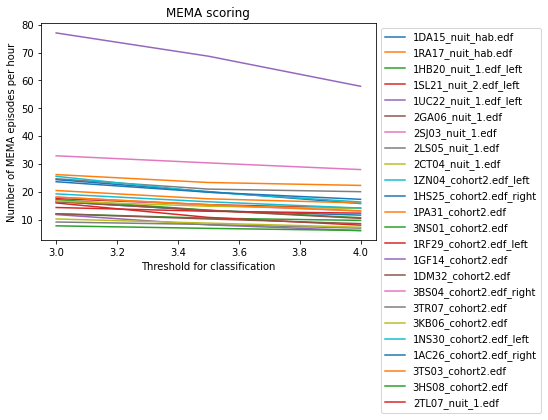

In [5]:
plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
plot_inter_subjects(results, value)

## 2.b Burst Duration 

<Figure size 432x288 with 0 Axes>

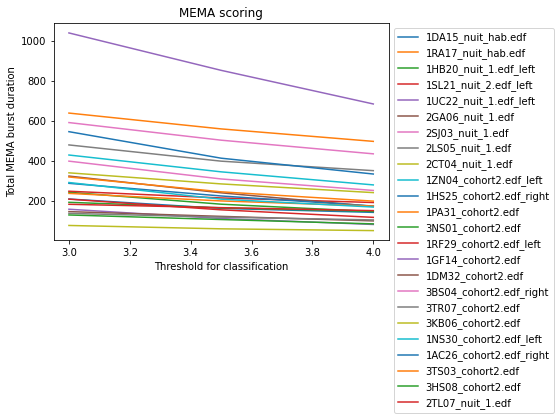

In [6]:
plt.figure()
plt.figure()
value = "Total MEMA burst duration"
plot_inter_subjects(results, value)

## 2.d Comparing episode frequency with variability tinnitus

Nb_patients in each group : 
Tinnitus decrease : 9, ['1DA15', '1HB20', '1SL21', '1ZN04', '3NS01', '3BS04', '3TR07', '3KB06', '3HS08']
Tinnitus increase : 8, ['1RA17', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus control : 5, ['2GA06', '2SJ03', '2LS05', '2CT04', '2TL07']
Tinnitus stable : 2, ['1PA31', '1RF29']
test for THR = 3 : 
Ttest_indResult(statistic=-0.9681141576528633, pvalue=0.3537916743444147)
Ttest_indResult(statistic=-1.5429660823732336, pvalue=0.14367009483238904)
Ttest_indResult(statistic=-0.5891941786916027, pvalue=0.5719893814429919)
test for THR = 3.5 : 
Ttest_indResult(statistic=-0.8818111927266437, pvalue=0.39673887354985693)
Ttest_indResult(statistic=-1.3922255408618975, pvalue=0.18415185497570938)
Ttest_indResult(statistic=-0.637396892945032, pvalue=0.5416741442765476)
test for THR = 4 : 
Ttest_indResult(statistic=-0.7582678310090041, pvalue=0.4642271367311761)
Ttest_indResult(statistic=-1.2915688132306147, pvalue=0.21605441940341258)
Ttest

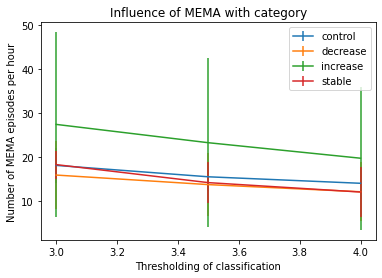

In [7]:
# d.1 GROUP BY TINNITUS VOLUME VARIATION
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)
        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["mask_delta"].apply(map_category)
#data_info["filename"] = data_info["Ear_select"]
data_info["filename"] = data_info["Controlateral"]
#data_info["filename"] = data_info["Right_ears"]
#print(data_info["filename"])

reports = reports.merge(data_info, on="filename")

# d.2 Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()


# d.3 Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()
          
l=[]
for i in range(12):
    #print(list(reports.groupby(['category', 'THR_classif']))[i][0])
    #print(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
print("test for THR = 3 : ")
print(scipy.stats.ttest_ind(l[0], l[6]))
print(scipy.stats.ttest_ind(l[3], l[6]))
print(scipy.stats.ttest_ind(l[9], l[6]))
print("test for THR = 3.5 : ")
print(scipy.stats.ttest_ind(l[1], l[7]))
print(scipy.stats.ttest_ind(l[4], l[7]))
print(scipy.stats.ttest_ind(l[10], l[7]))
print("test for THR = 4 : ")
print(scipy.stats.ttest_ind(l[2], l[8]))
print(scipy.stats.ttest_ind(l[5], l[8]))
print(scipy.stats.ttest_ind(l[11], l[8]))

## 2.e Etiology

etiology (?) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04']
etiology (group1) : 21, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
etiology (group3) : 18, ['3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_3.0 v.s. group1_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.600e+01
group1_3.0 v.s. group3_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.739e-01 U_stat=3.000e+01
?_3.0 

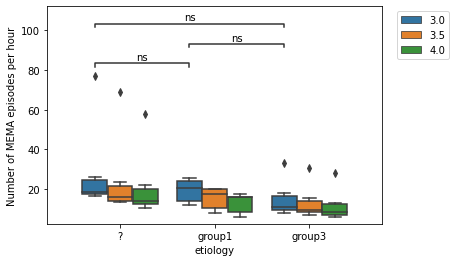

obstructed_ear (False) : 27, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
obstructed_ear (True) : 30, ['1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.779e-01 U_stat=2.800e+01


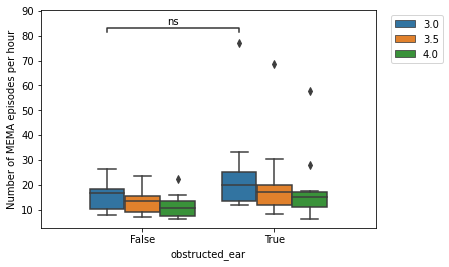

otalgy (False) : 45, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03']
otalgy (True) : 12, ['1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1AC26', '1AC26', '1AC26', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.157e-01 U_stat=3.700e+01


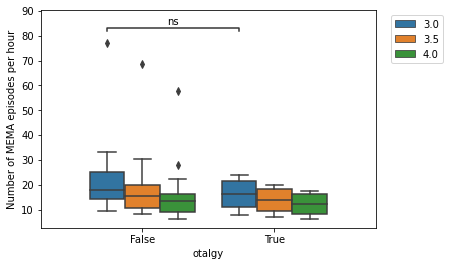

hyperacusis (True) : 27, ['1DA15', '1DA15', '1DA15', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
hyperacusis (False) : 30, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.734e-02 U_stat=7.100e+01


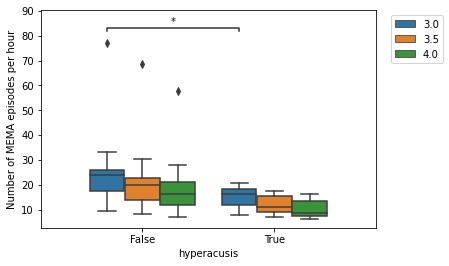

jaw_popping (True) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
jaw_popping (False) : 21, ['1HB20', '1HB20', '1HB20', '1UC22', '1UC22', '1UC22', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.037e-01 U_stat=3.700e+01


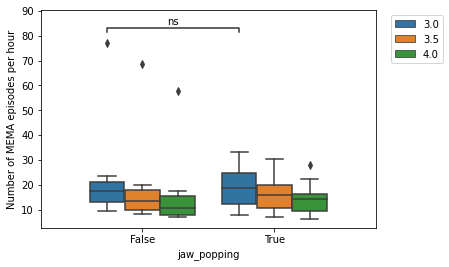

jaw_pain_and_fatigue (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
jaw_pain_and_fatigue (True) : 15, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.795e-01 U_stat=2.000e+01


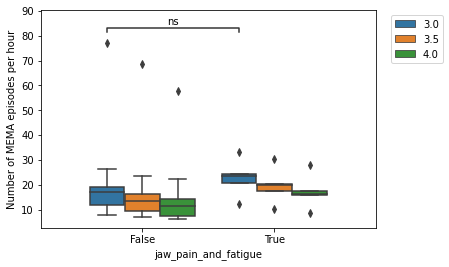

somatosensory_modulation (False) : 33, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
somatosensory_modulation (True) : 24, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.585e-02 U_stat=2.200e+01


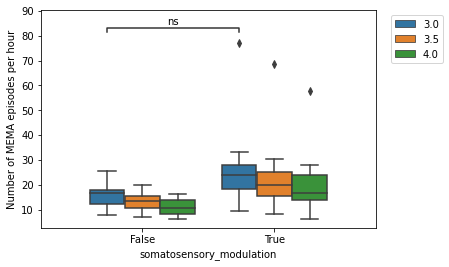

nap_modulation (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
nap_modulation (True) : 15, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.791e-01 U_stat=2.500e+01


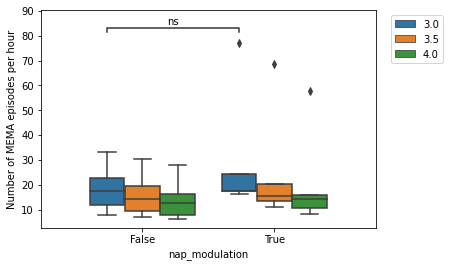

snoring (False) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
snoring (True) : 21, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.037e-01 U_stat=3.700e+01


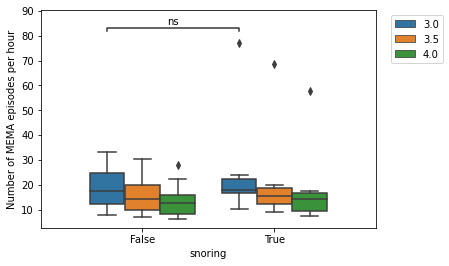

neck_pain (True) : 36, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
neck_pain (False) : 21, ['1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.828e-01 U_stat=4.900e+01


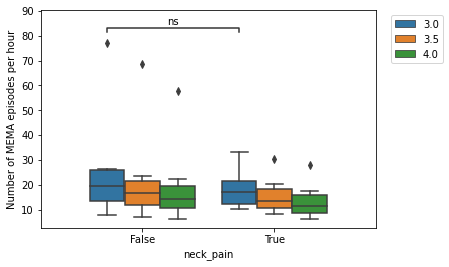

trauma_sonore (True) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
trauma_sonore (False) : 39, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.264e-01 U_stat=3.600e+01


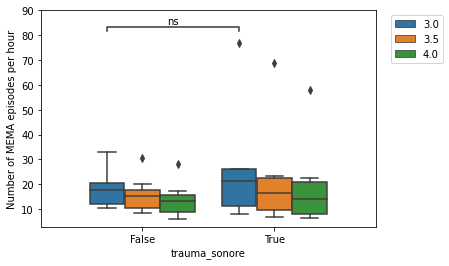

otite (False) : 30, ['1DA15', '1DA15', '1DA15', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
otite (True) : 27, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.364e-01 U_stat=3.000e+01


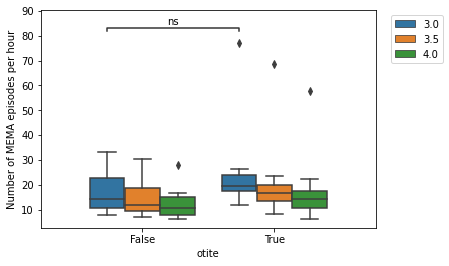

Ear clapping (False) : 24, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06']
Ear clapping (True) : 33, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.0 v.s. True_3.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.328e-01 U_stat=3.400e+01


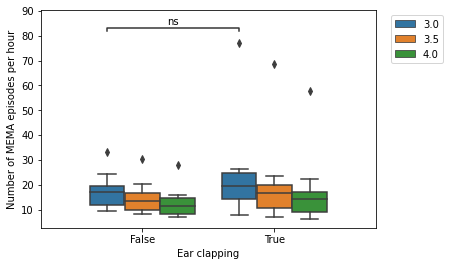

etiology (?) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04']
etiology (group1) : 21, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
etiology (group3) : 18, ['3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_3.5 v.s. group1_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.600e+01
group1_3.5 v.s. group3_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.800e+01
?_3.5 

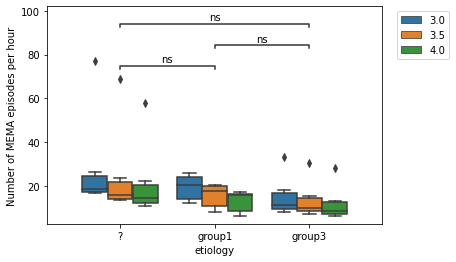

obstructed_ear (False) : 27, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
obstructed_ear (True) : 30, ['1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.364e-01 U_stat=3.000e+01


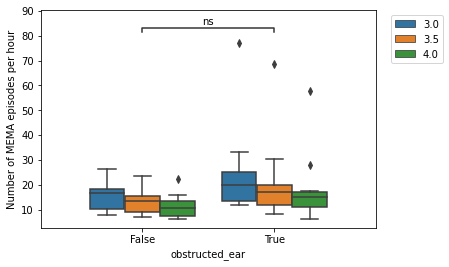

otalgy (False) : 45, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03']
otalgy (True) : 12, ['1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1AC26', '1AC26', '1AC26', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.823e-01 U_stat=3.600e+01


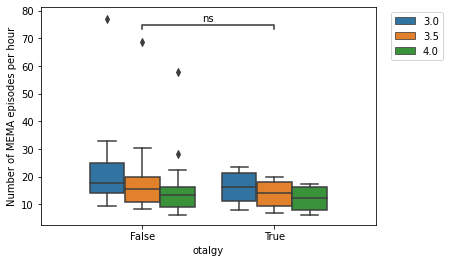

hyperacusis (True) : 27, ['1DA15', '1DA15', '1DA15', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
hyperacusis (False) : 30, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.474e-02 U_stat=7.300e+01


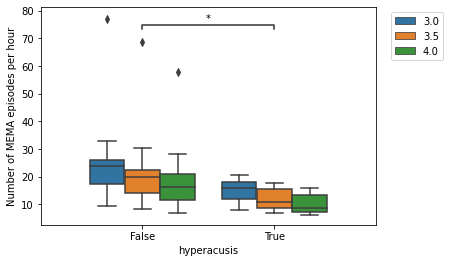

jaw_popping (True) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
jaw_popping (False) : 21, ['1HB20', '1HB20', '1HB20', '1UC22', '1UC22', '1UC22', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.327e-01 U_stat=3.900e+01


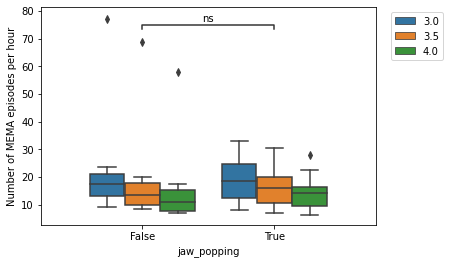

jaw_pain_and_fatigue (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
jaw_pain_and_fatigue (True) : 15, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.266e-01 U_stat=1.800e+01


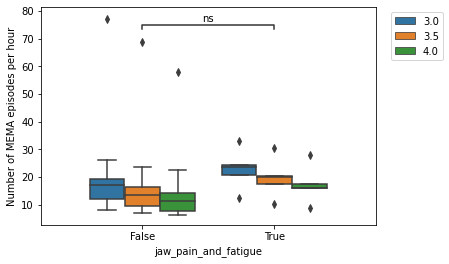

somatosensory_modulation (False) : 33, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
somatosensory_modulation (True) : 24, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.319e-02 U_stat=2.100e+01


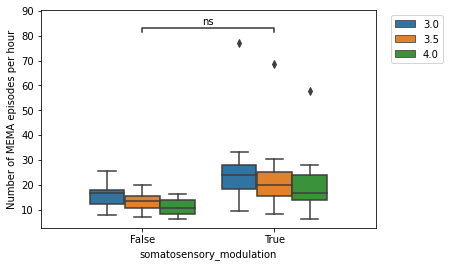

nap_modulation (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
nap_modulation (True) : 15, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.870e-01 U_stat=2.300e+01


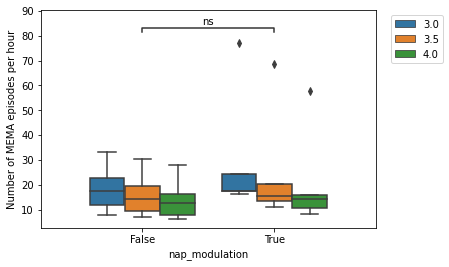

snoring (False) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
snoring (True) : 21, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.262e-01 U_stat=3.400e+01


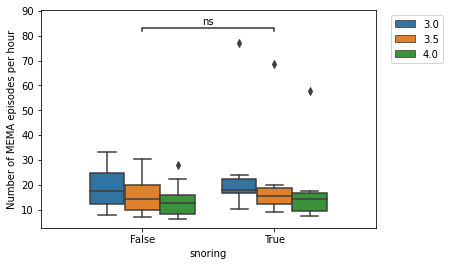

neck_pain (True) : 36, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
neck_pain (False) : 21, ['1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.828e-01 U_stat=4.900e+01


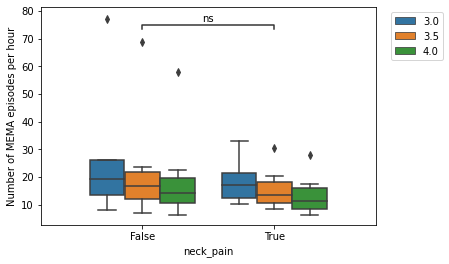

trauma_sonore (True) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
trauma_sonore (False) : 39, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.953e-01 U_stat=3.700e+01


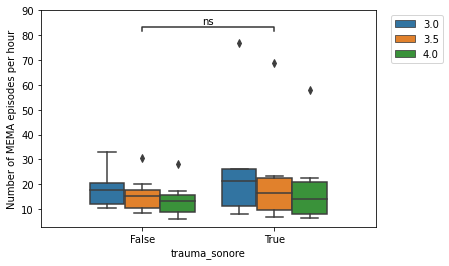

otite (False) : 30, ['1DA15', '1DA15', '1DA15', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
otite (True) : 27, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.364e-01 U_stat=3.000e+01


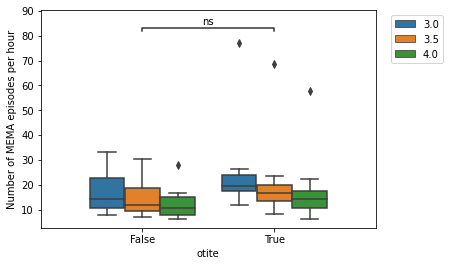

Ear clapping (False) : 24, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06']
Ear clapping (True) : 33, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3.5 v.s. True_3.5: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.497e-01 U_stat=3.800e+01


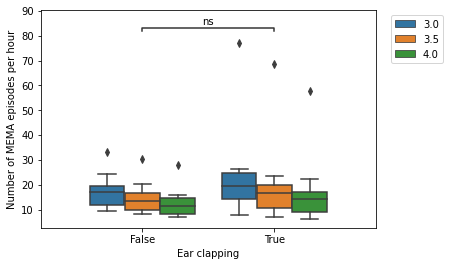

etiology (?) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04']
etiology (group1) : 21, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
etiology (group3) : 18, ['3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_4.0 v.s. group1_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.600e+01
group1_4.0 v.s. group3_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.600e+01
?_4.0 

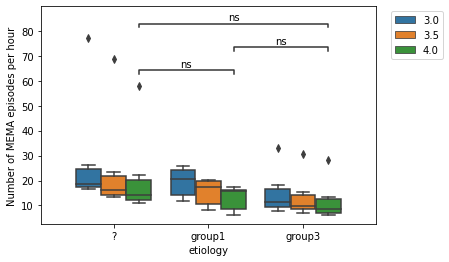

obstructed_ear (False) : 27, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
obstructed_ear (True) : 30, ['1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.309e-01 U_stat=2.600e+01


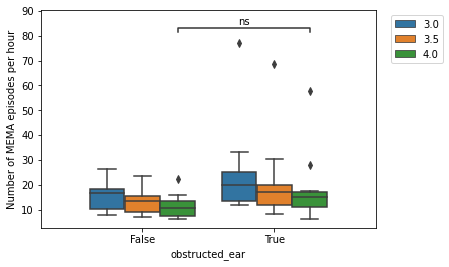

otalgy (False) : 45, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03']
otalgy (True) : 12, ['1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '1AC26', '1AC26', '1AC26', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.808e-01 U_stat=3.200e+01


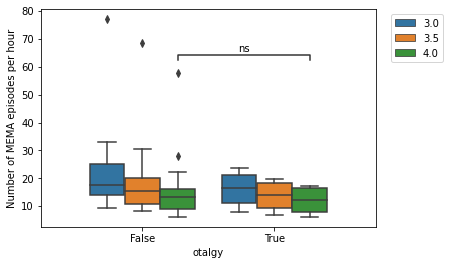

hyperacusis (True) : 27, ['1DA15', '1DA15', '1DA15', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
hyperacusis (False) : 30, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.049e-02 U_stat=7.200e+01


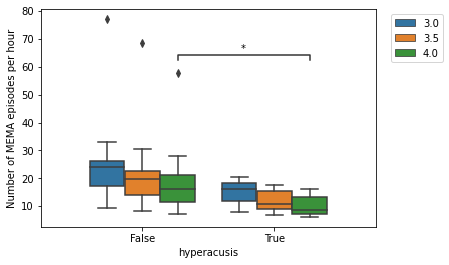

jaw_popping (True) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
jaw_popping (False) : 21, ['1HB20', '1HB20', '1HB20', '1UC22', '1UC22', '1UC22', '1RF29', '1RF29', '1RF29', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.037e-01 U_stat=3.700e+01


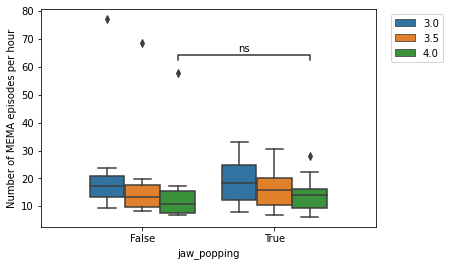

jaw_pain_and_fatigue (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
jaw_pain_and_fatigue (True) : 15, ['1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.266e-01 U_stat=1.800e+01


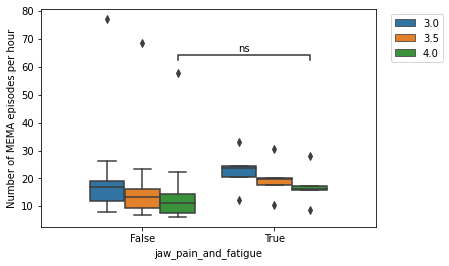

somatosensory_modulation (False) : 33, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1DM32', '1DM32', '1DM32', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
somatosensory_modulation (True) : 24, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '1GF14', '1GF14', '1GF14', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.051e-02 U_stat=2.300e+01


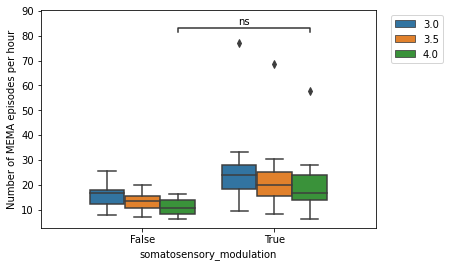

nap_modulation (False) : 42, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
nap_modulation (True) : 15, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1HS25', '1HS25', '1HS25', '1RF29', '1RF29', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.106e-01 U_stat=2.900e+01


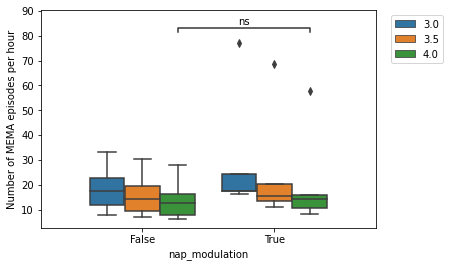

snoring (False) : 36, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
snoring (True) : 21, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.828e-01 U_stat=3.500e+01


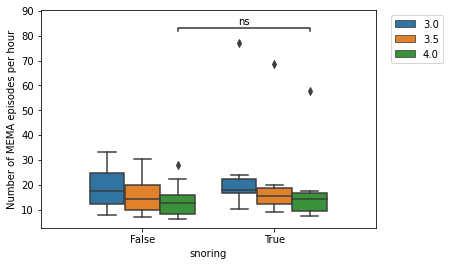

neck_pain (True) : 36, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
neck_pain (False) : 21, ['1RA17', '1RA17', '1RA17', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.725e-01 U_stat=5.100e+01


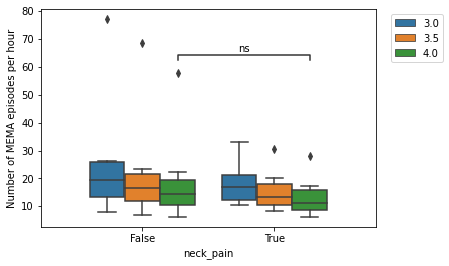

trauma_sonore (True) : 18, ['1DA15', '1DA15', '1DA15', '1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '3TR07', '3TR07', '3TR07', '1NS30', '1NS30', '1NS30', '3HS08', '3HS08', '3HS08']
trauma_sonore (False) : 39, ['1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1ZN04', '1ZN04', '1ZN04', '1HS25', '1HS25', '1HS25', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3KB06', '3KB06', '3KB06', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.931e-01 U_stat=3.400e+01


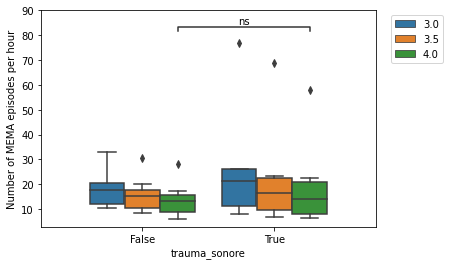

otite (False) : 30, ['1DA15', '1DA15', '1DA15', '1HS25', '1HS25', '1HS25', '3NS01', '3NS01', '3NS01', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06', '1NS30', '1NS30', '1NS30', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
otite (True) : 27, ['1RA17', '1RA17', '1RA17', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1AC26', '1AC26', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.074e-01 U_stat=3.200e+01


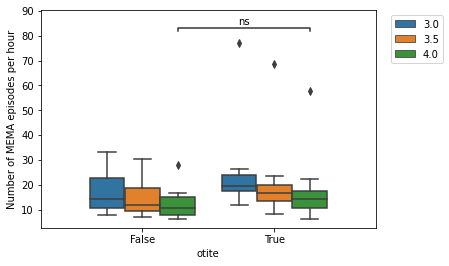

Ear clapping (False) : 24, ['1DA15', '1DA15', '1DA15', '1HB20', '1HB20', '1HB20', '1SL21', '1SL21', '1SL21', '1HS25', '1HS25', '1HS25', '1DM32', '1DM32', '1DM32', '3BS04', '3BS04', '3BS04', '3TR07', '3TR07', '3TR07', '3KB06', '3KB06', '3KB06']
Ear clapping (True) : 33, ['1RA17', '1RA17', '1RA17', '1UC22', '1UC22', '1UC22', '1ZN04', '1ZN04', '1ZN04', '1PA31', '1PA31', '1PA31', '3NS01', '3NS01', '3NS01', '1RF29', '1RF29', '1RF29', '1GF14', '1GF14', '1GF14', '1NS30', '1NS30', '1NS30', '1AC26', '1AC26', '1AC26', '3TS03', '3TS03', '3TS03', '3HS08', '3HS08', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_4.0 v.s. True_4.0: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.357e-01 U_stat=3.600e+01


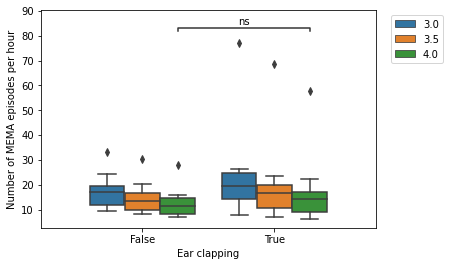

In [8]:
# e.1 GROUP BY ETIOLOGIES
plt.close("all")
from tinnsleep.visualization import etiology_report_with_plot

data = reports.query("category != 'control'")

variable = "Number of MEMA episodes per hour"
#variable = 'Number of MEMA bursts per episode'

for thr in [3,3.5,4]:
    hue = "THR_classif"
    threshold = thr

    etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
                'somatosensory_modulation', 'nap_modulation', 'snoring', "neck_pain", "trauma_sonore", "otite",
                 "Ear clapping"]

    for etiology in etiologies:
        etiology_report_with_plot(data, etiology, variable, hue=hue, hue_value_for_stats=threshold)
        plt.show()


## 2.f Screen for correlated variables

In [20]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())[0:-7] #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'MEMA episode NREM count', 'MEMA episode NREM ratio', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


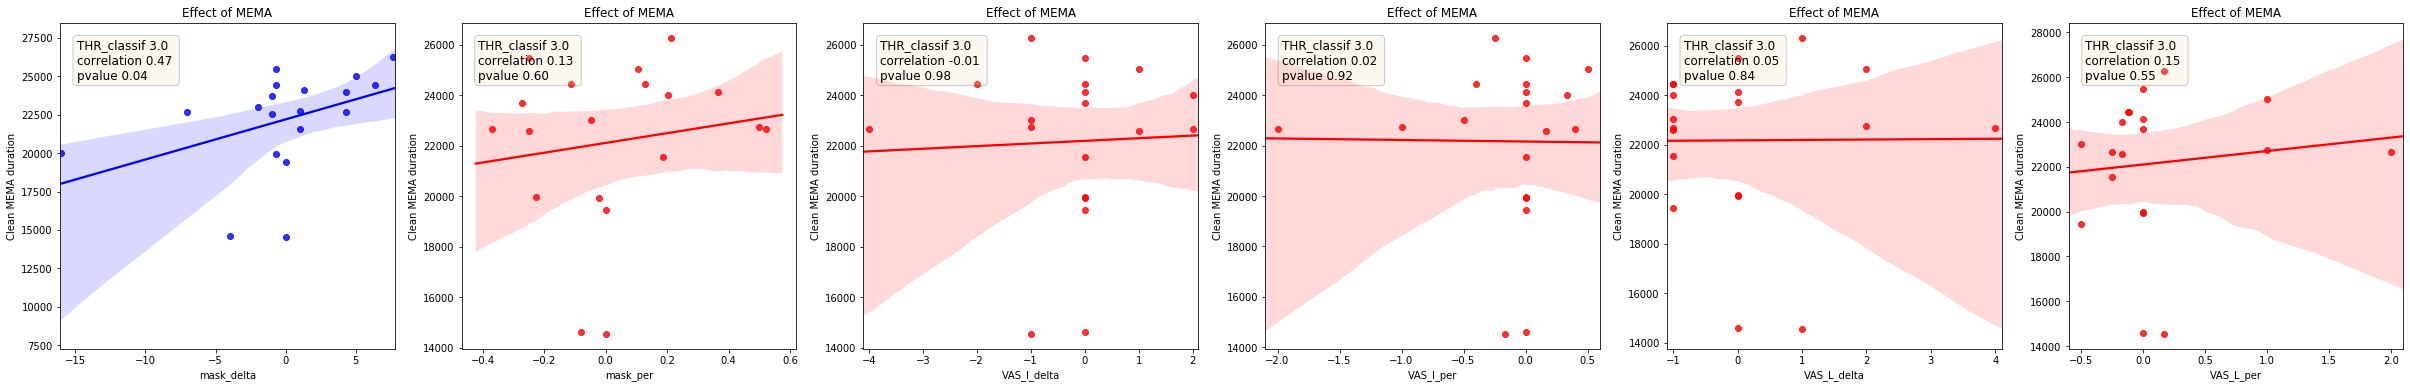

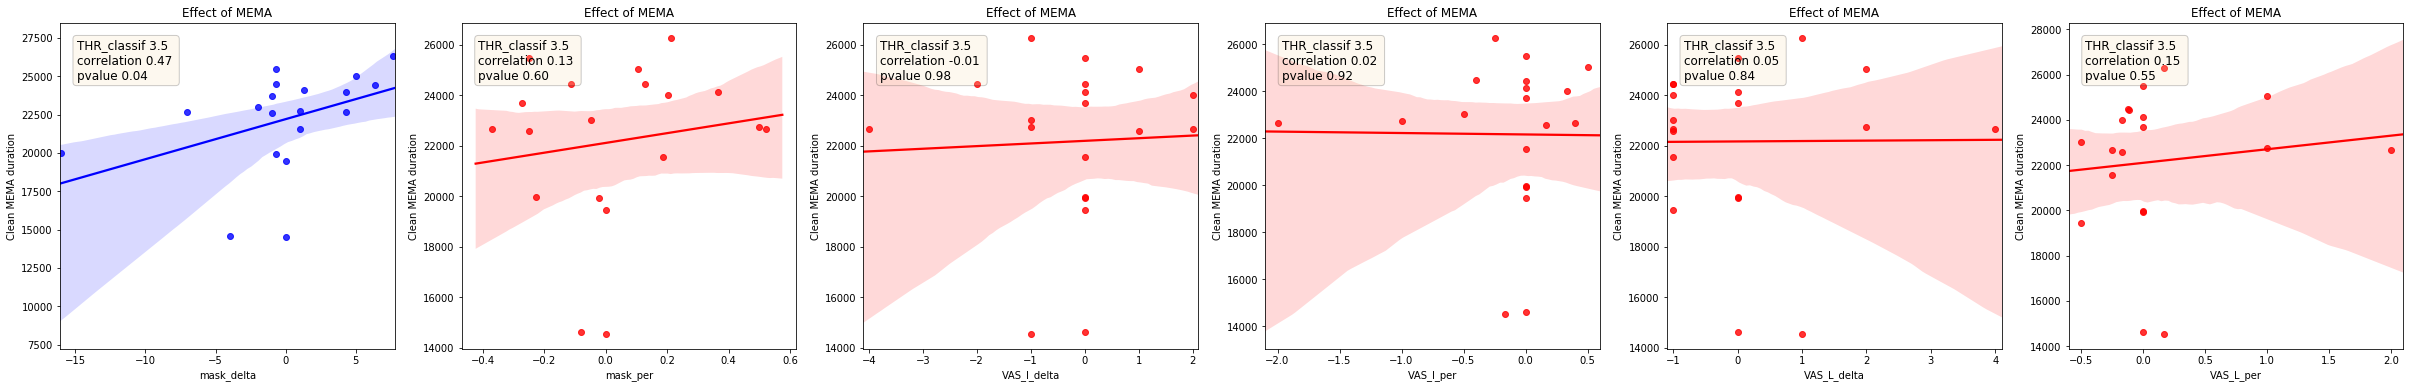

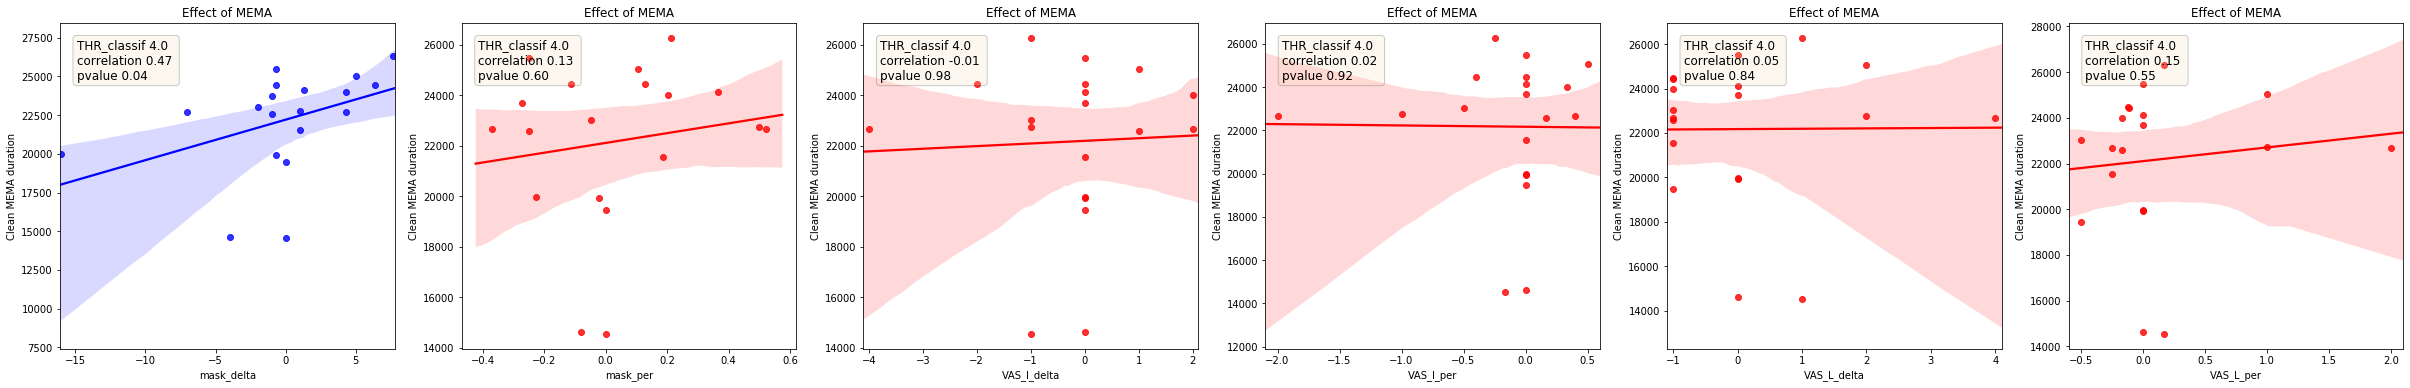

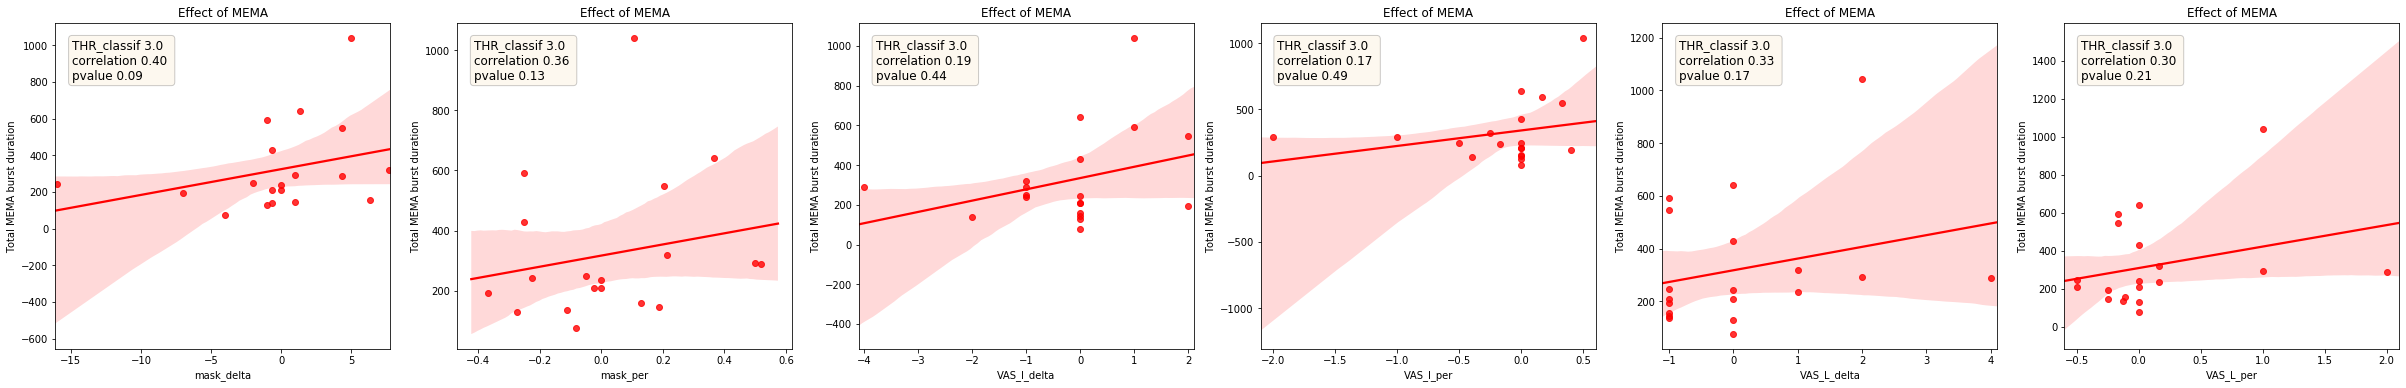

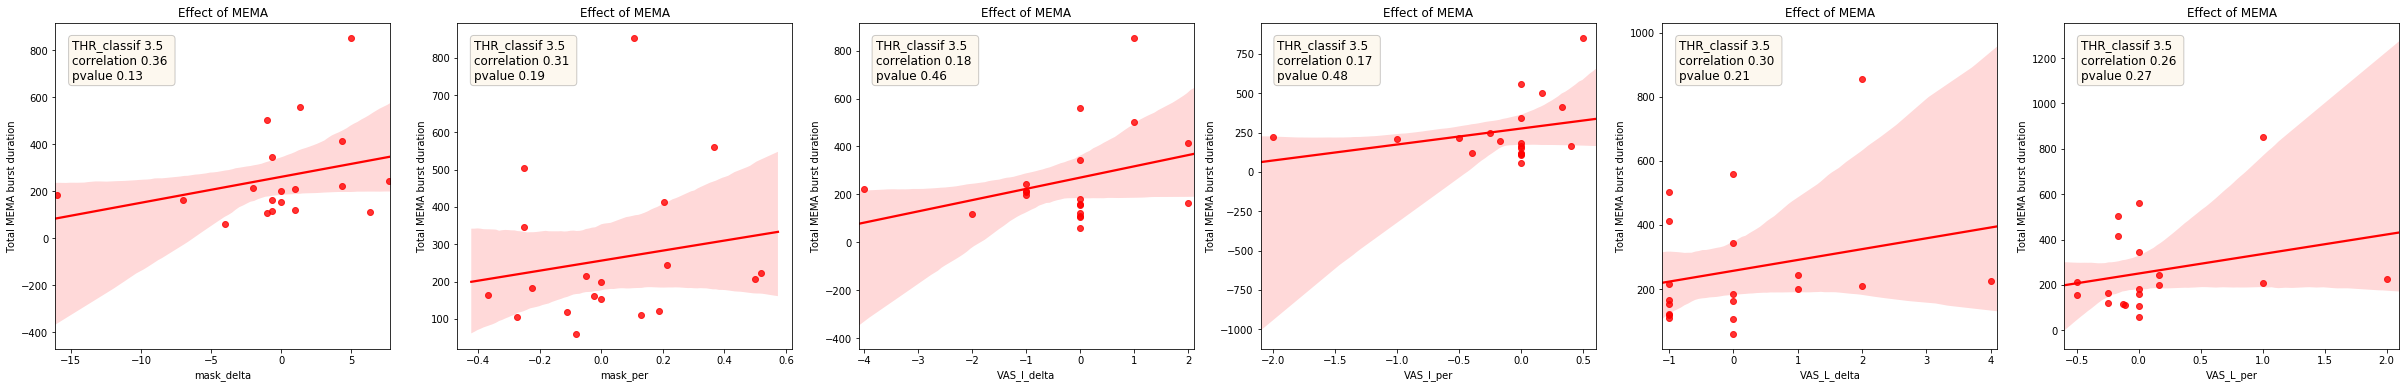

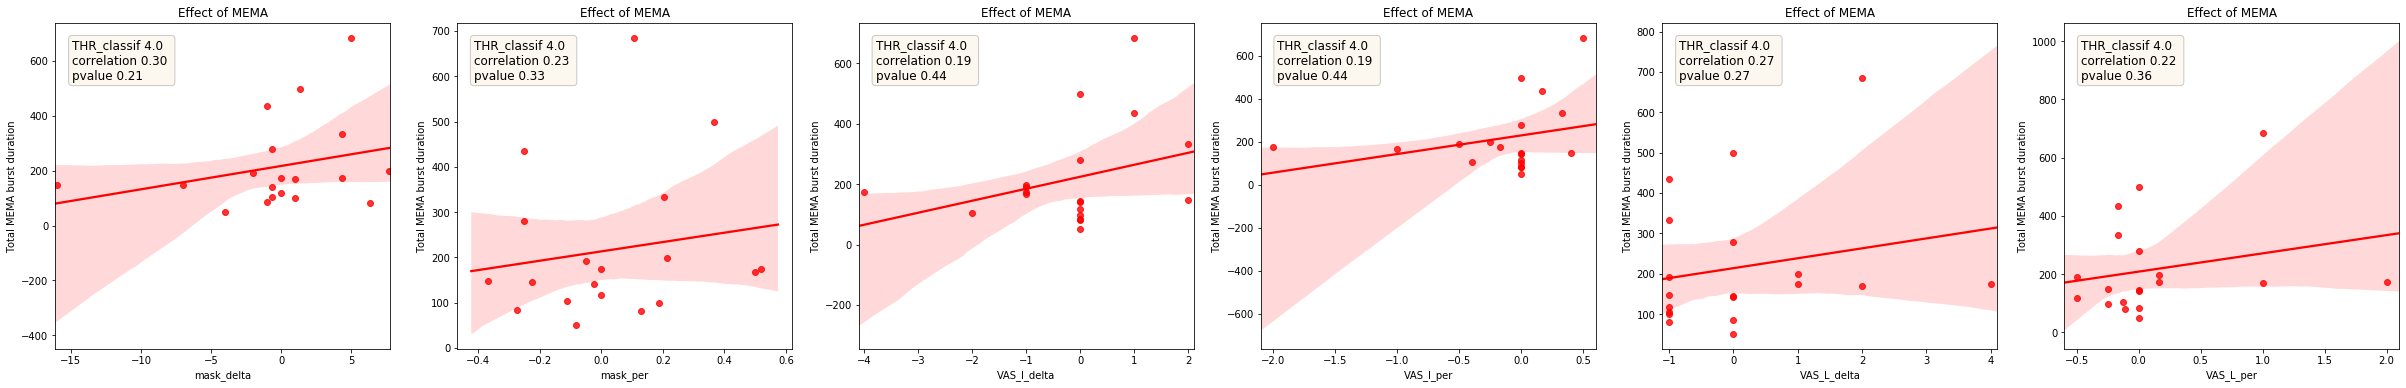

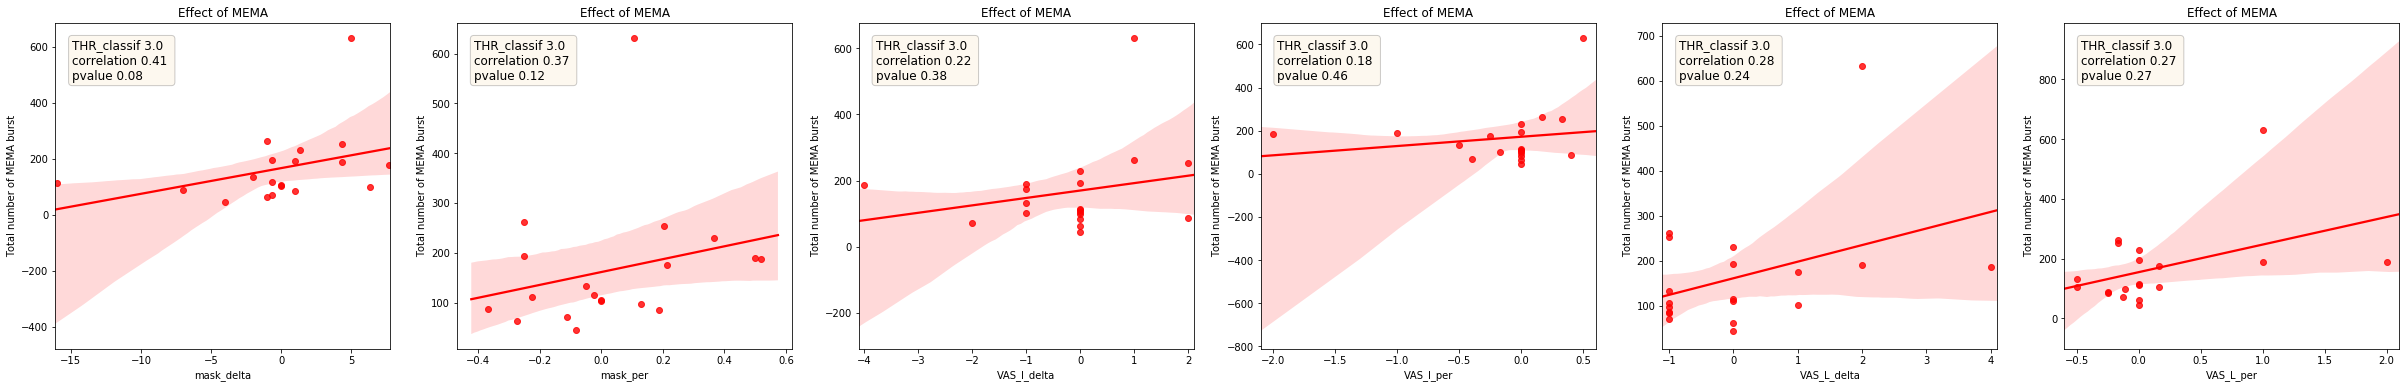

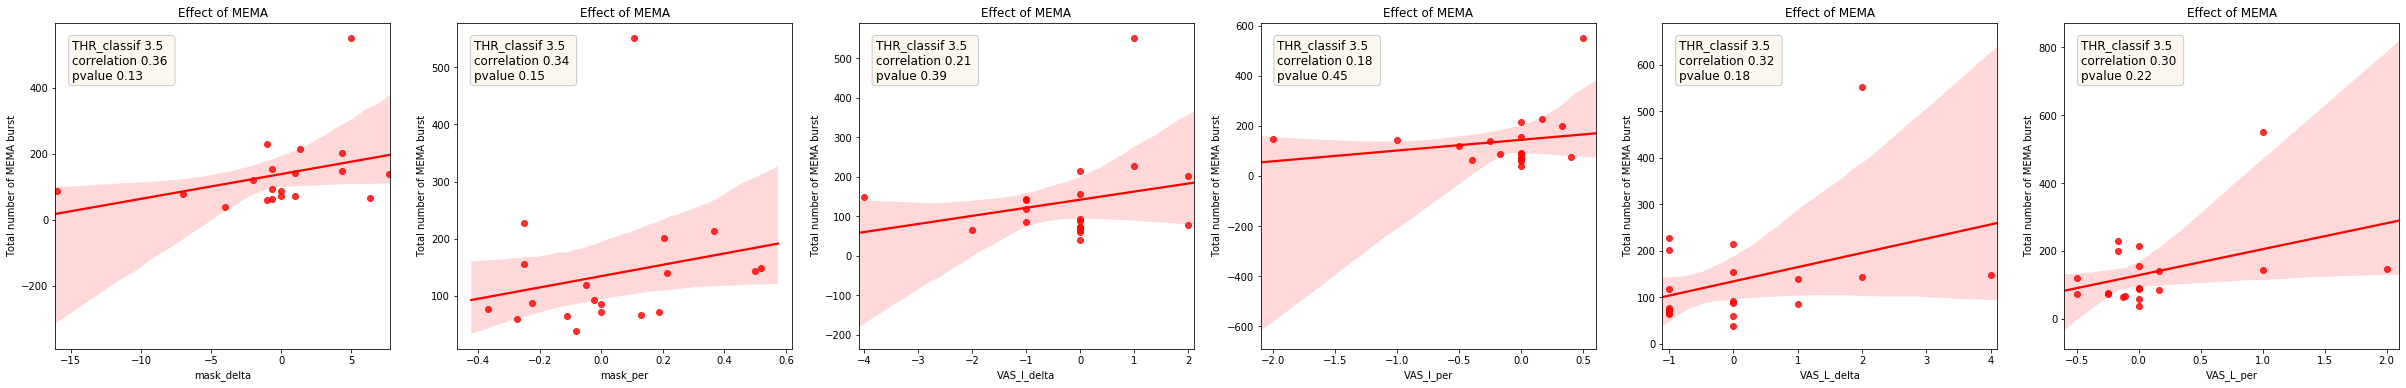

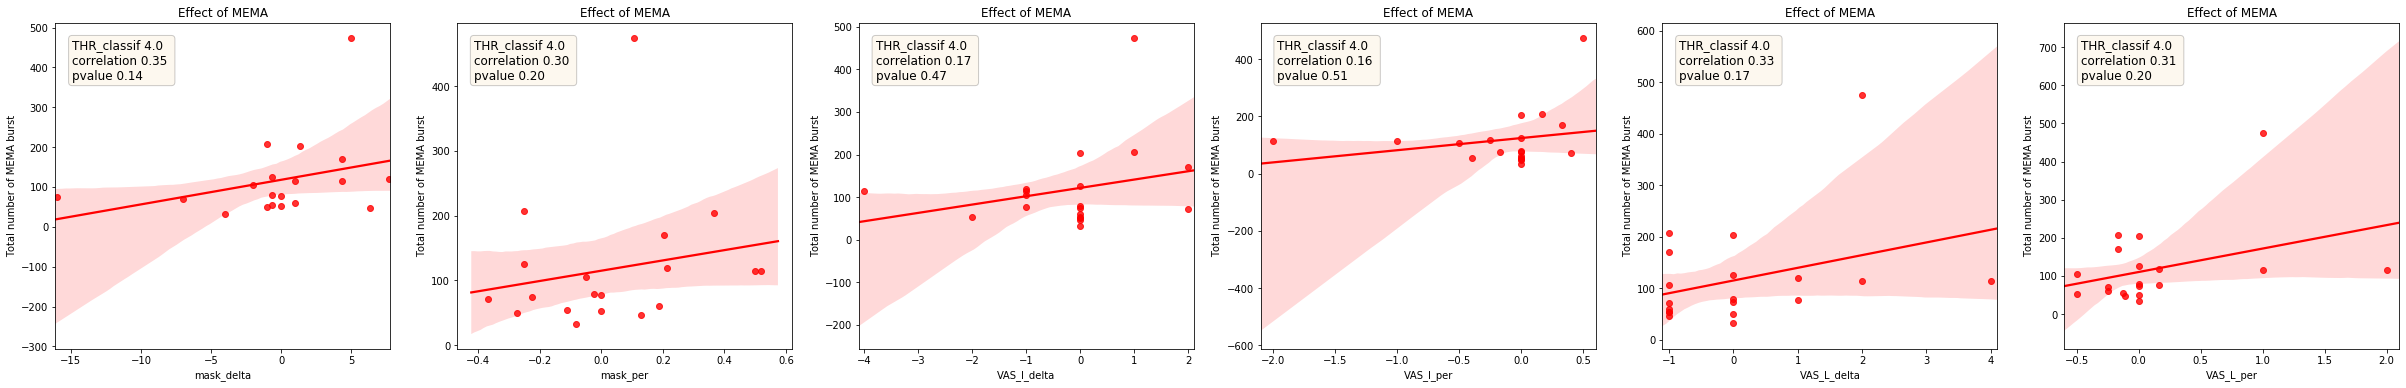

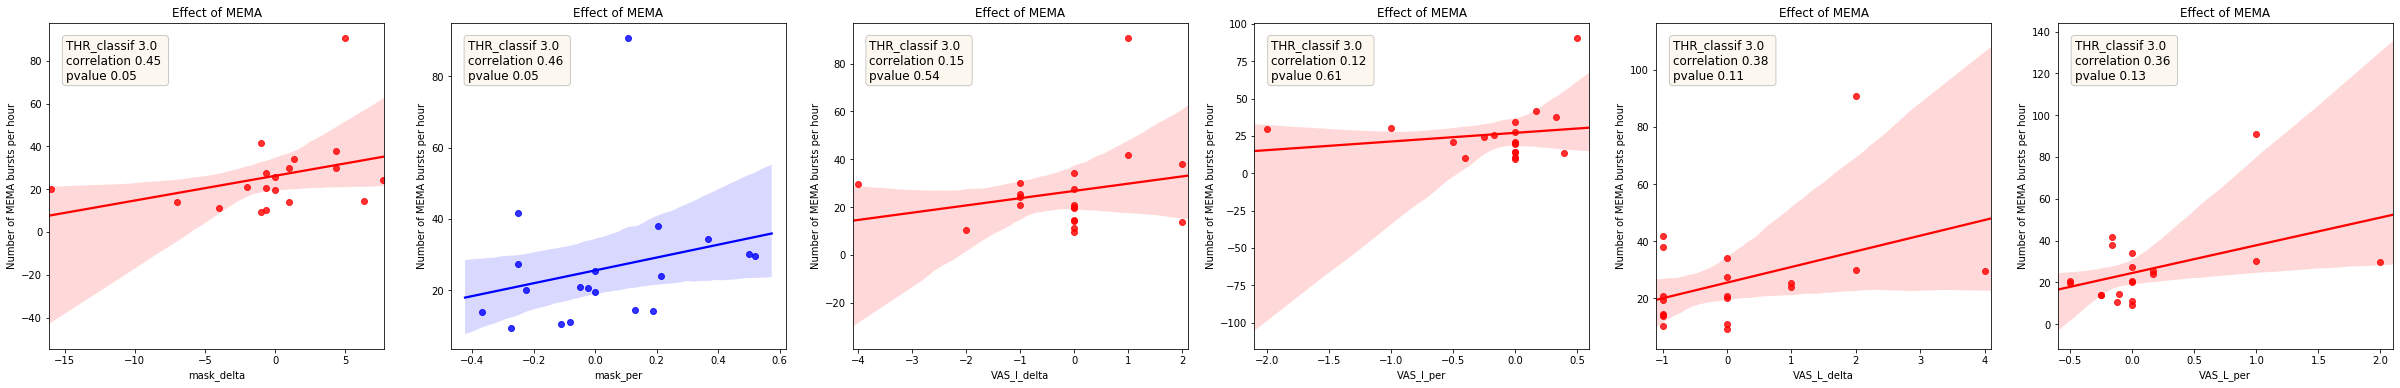

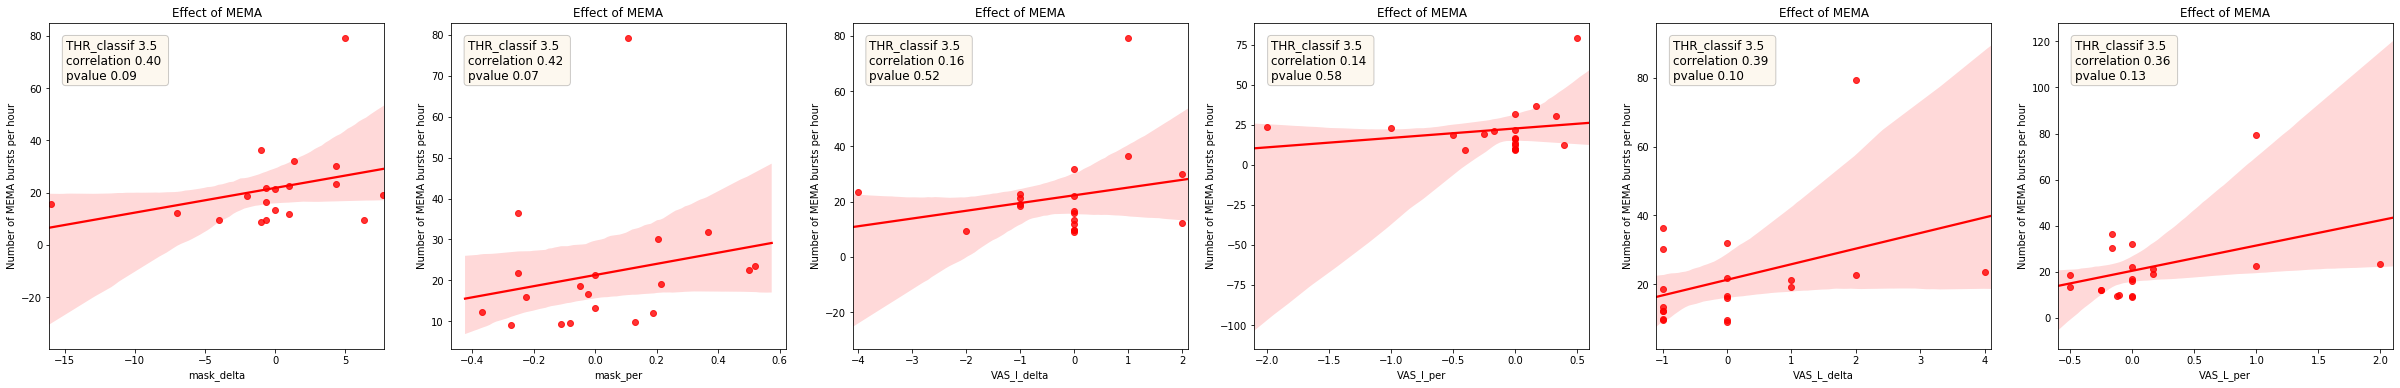

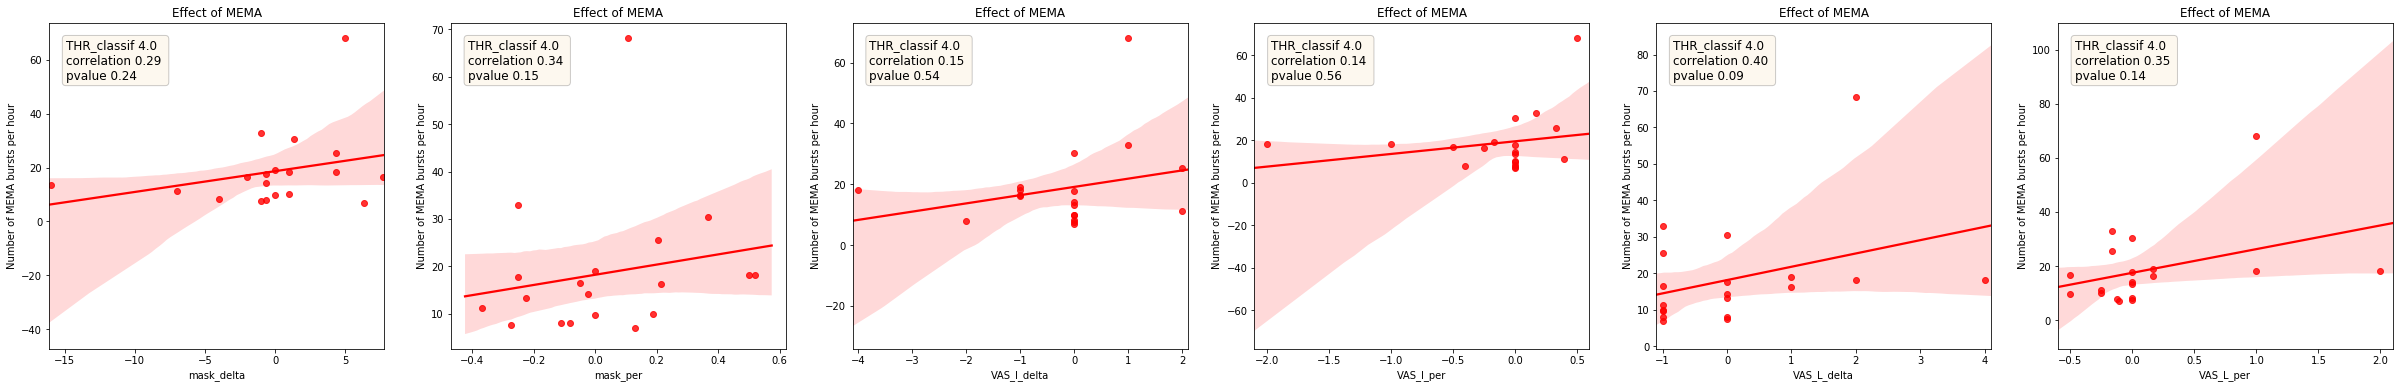

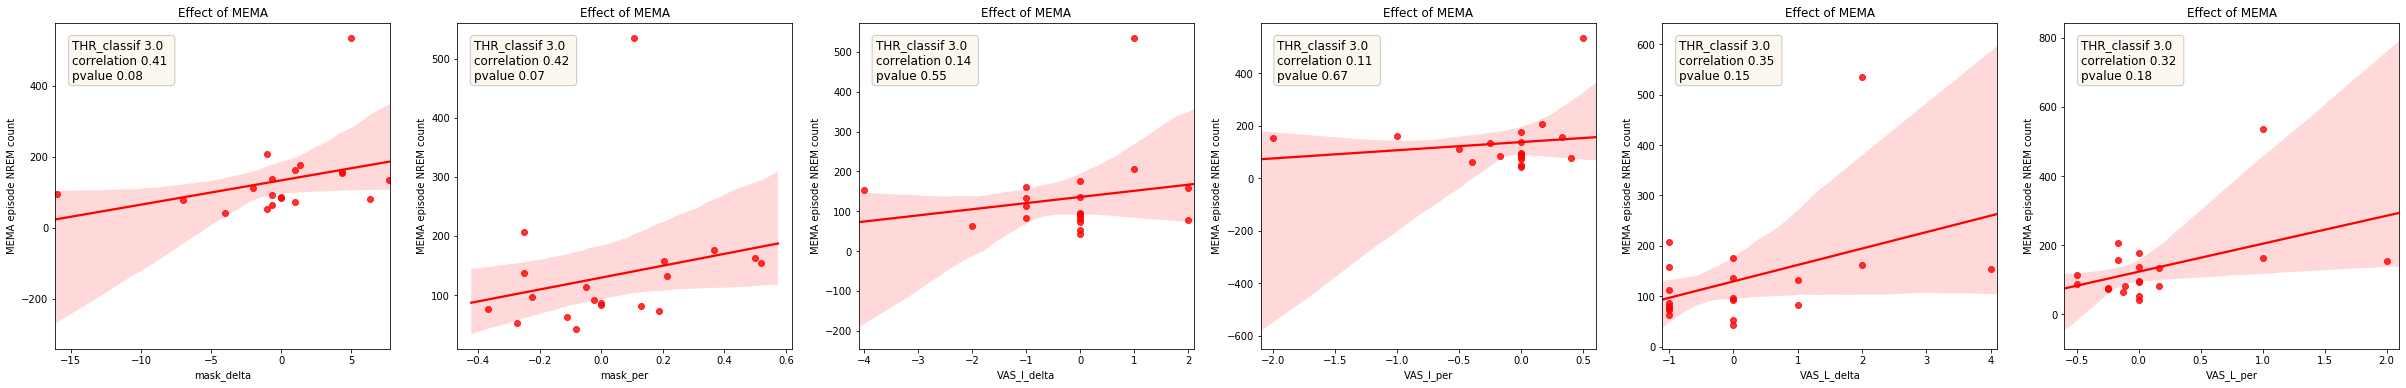

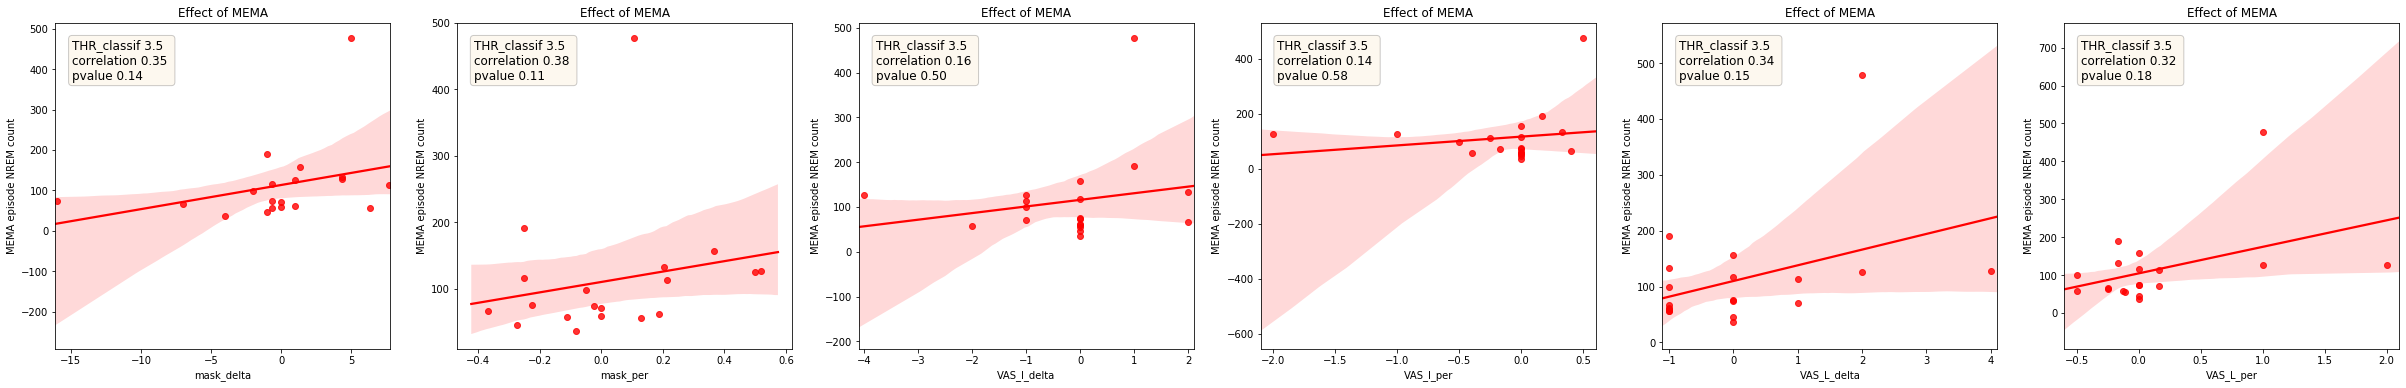

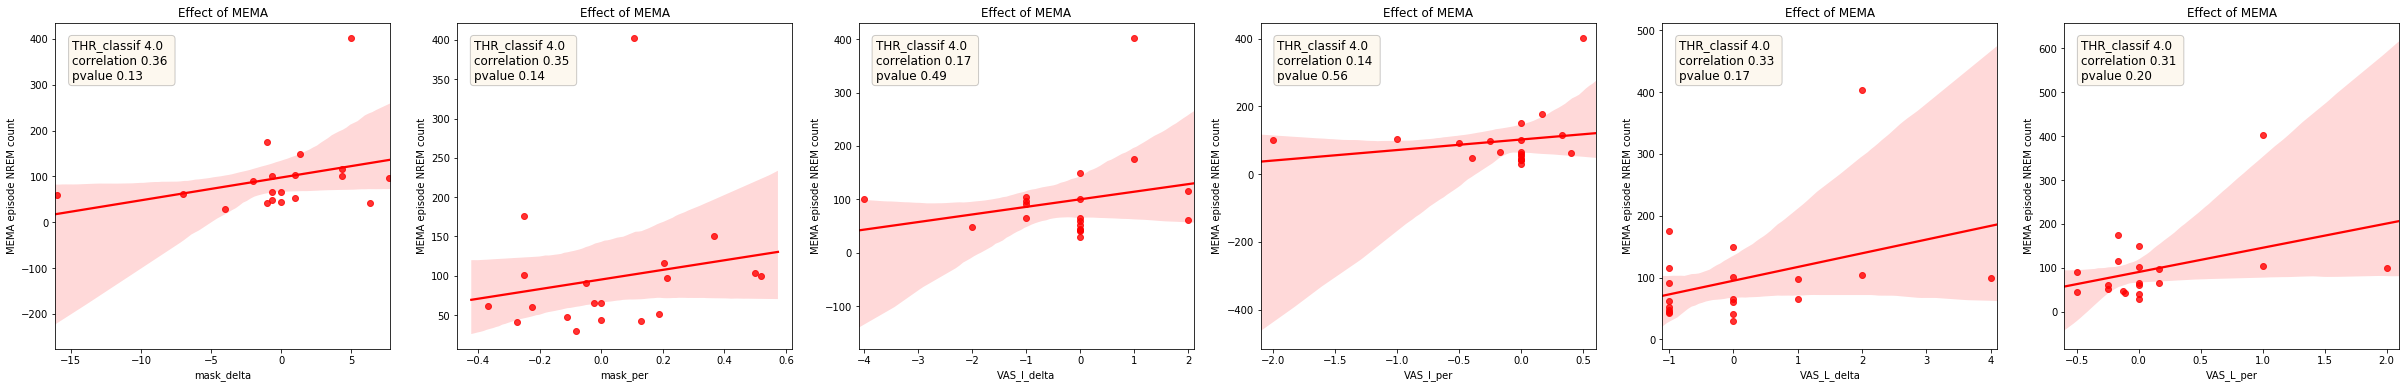

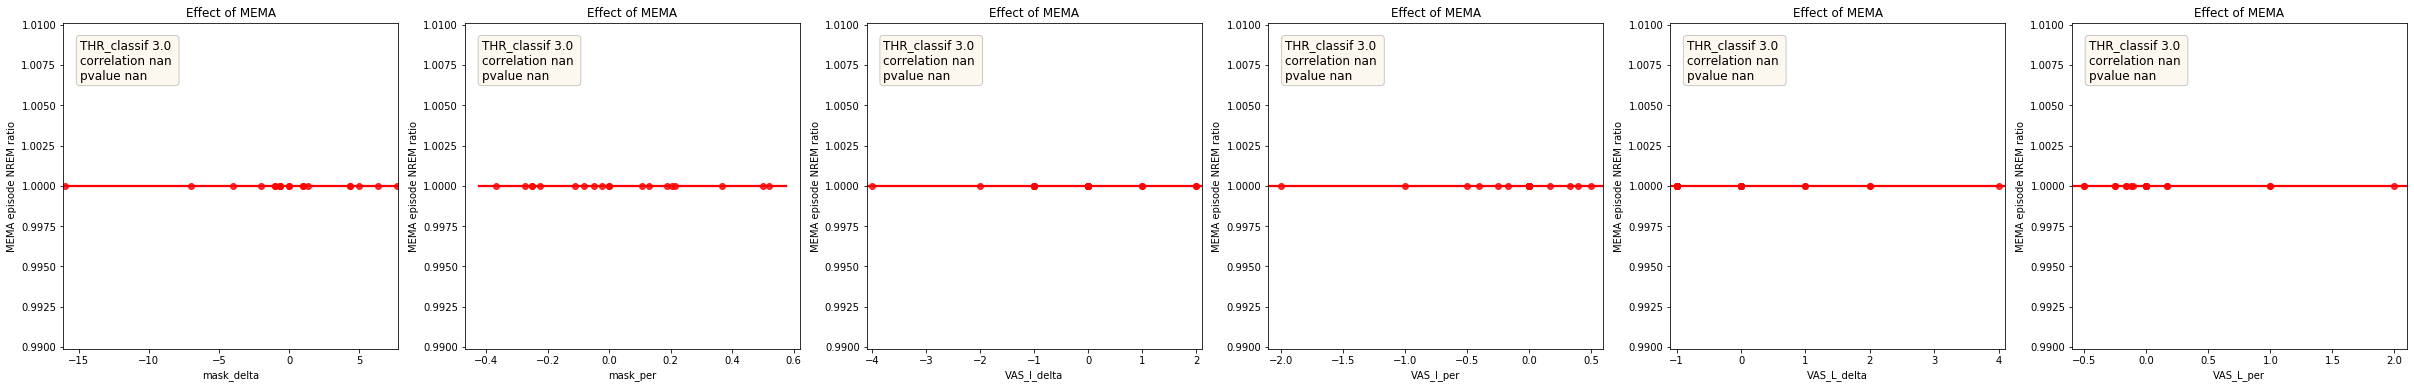

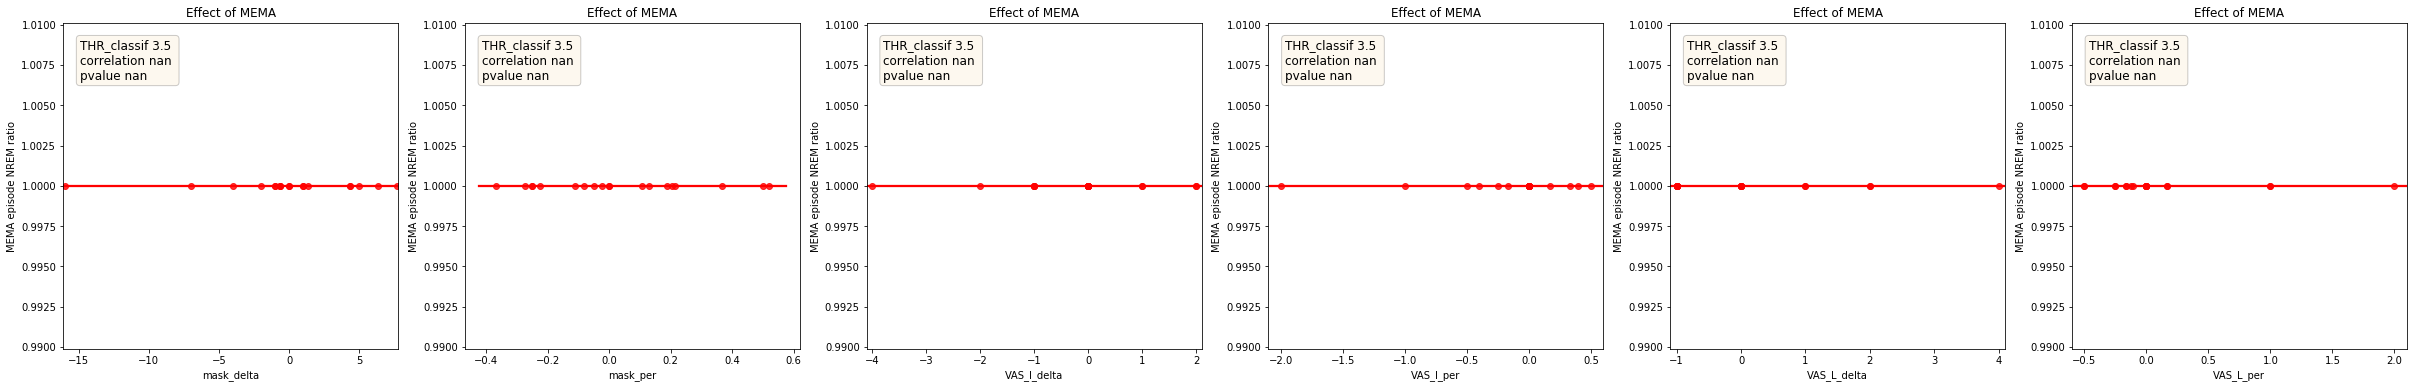

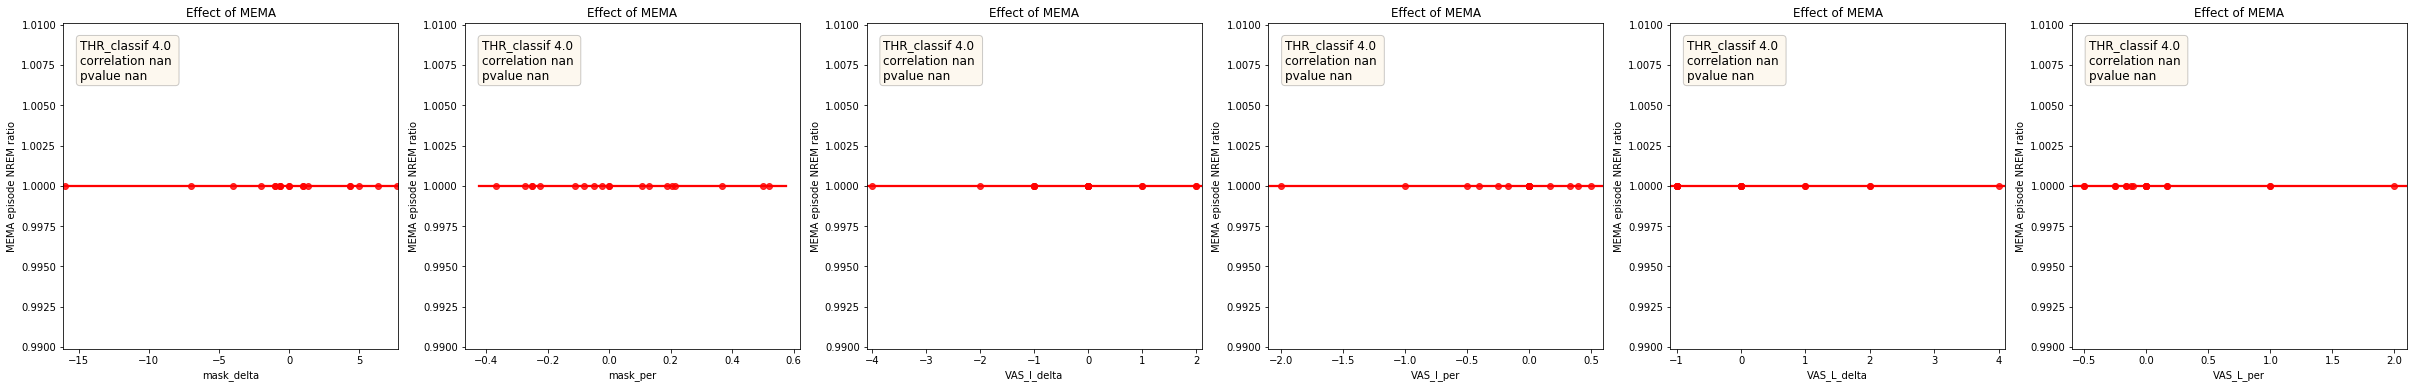

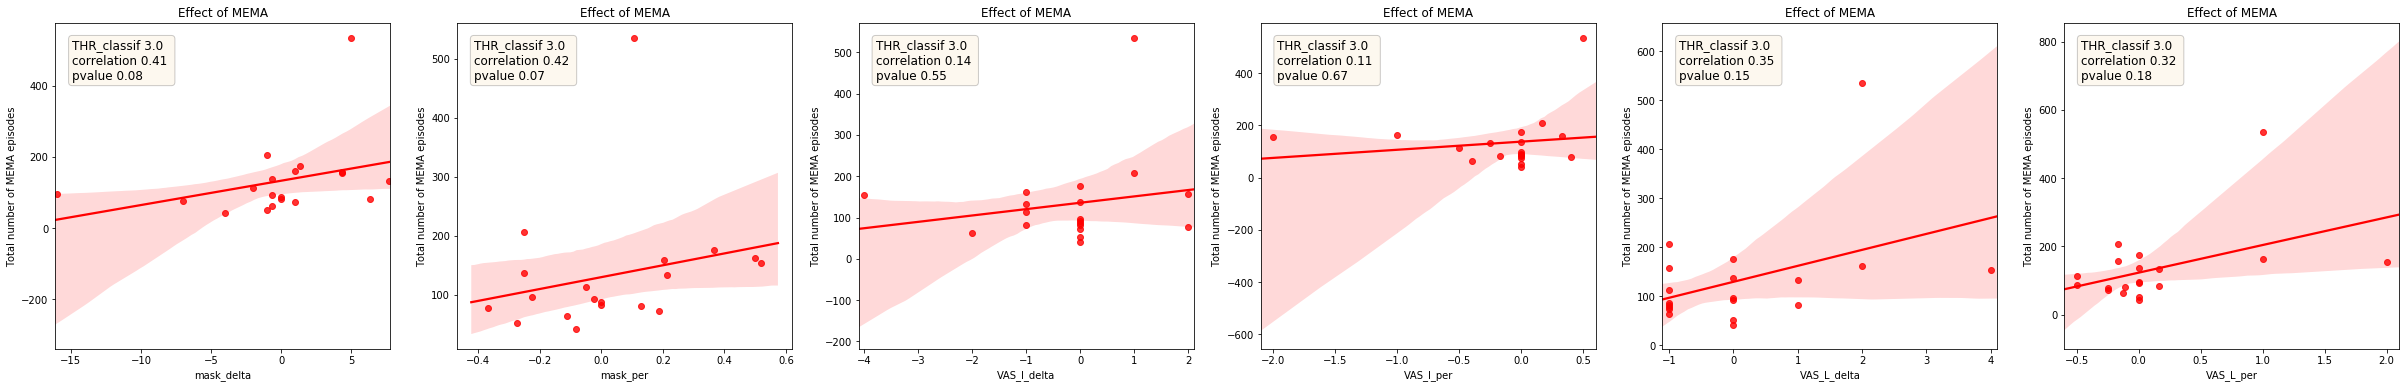

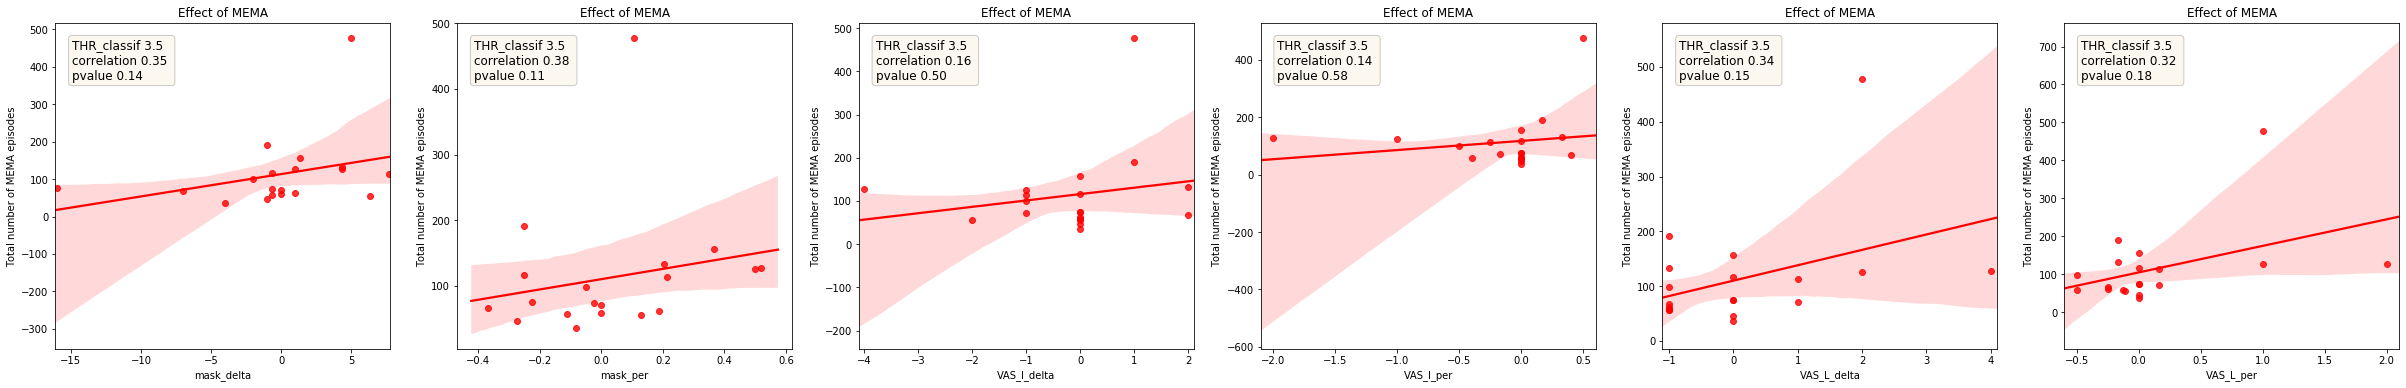

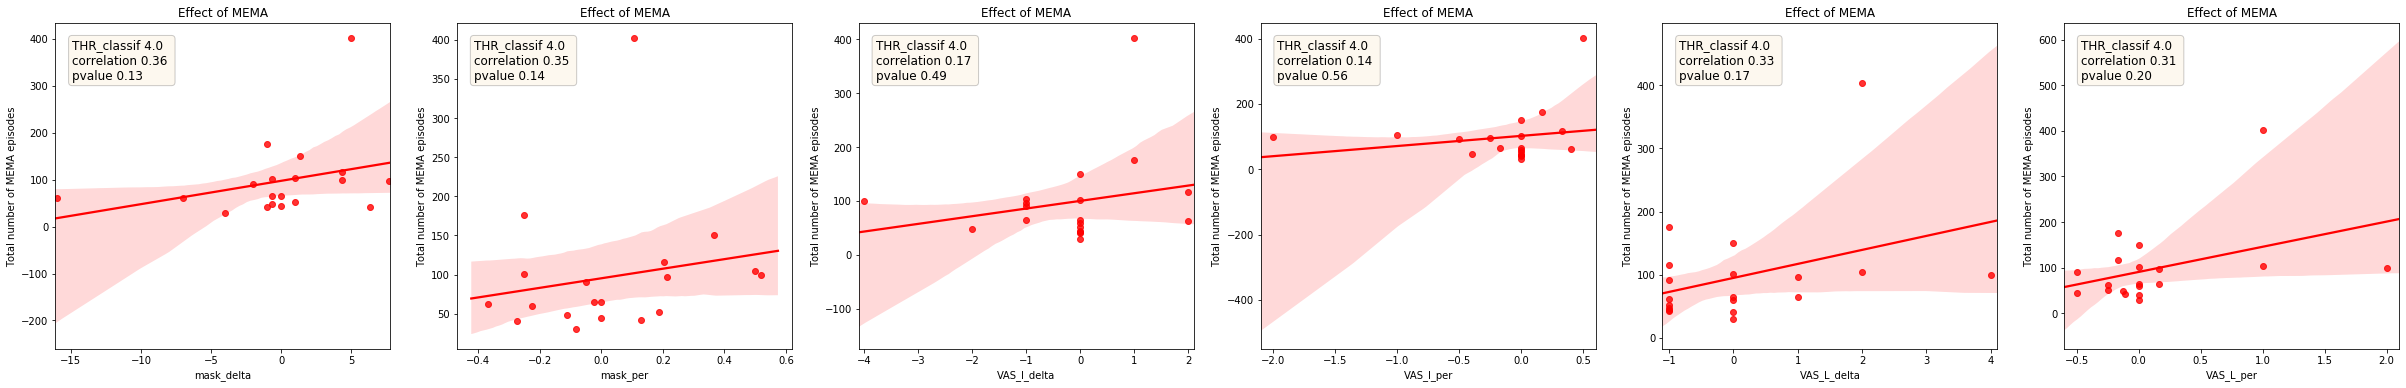

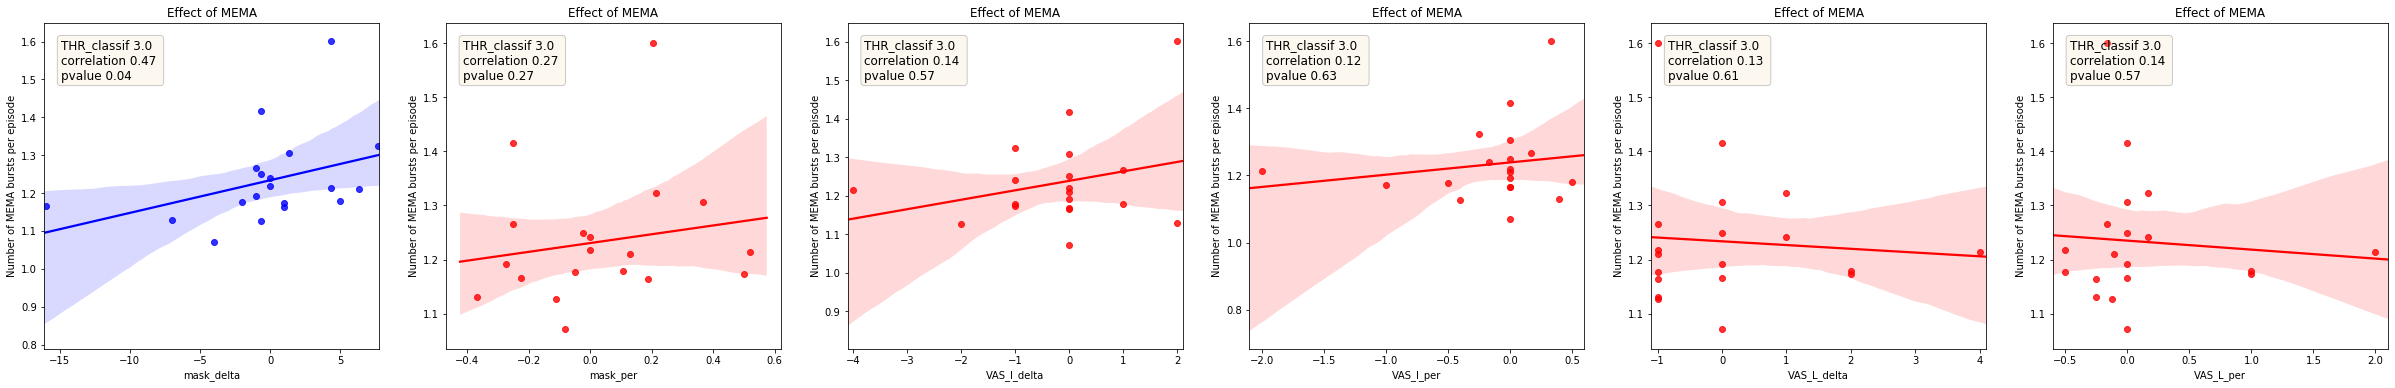

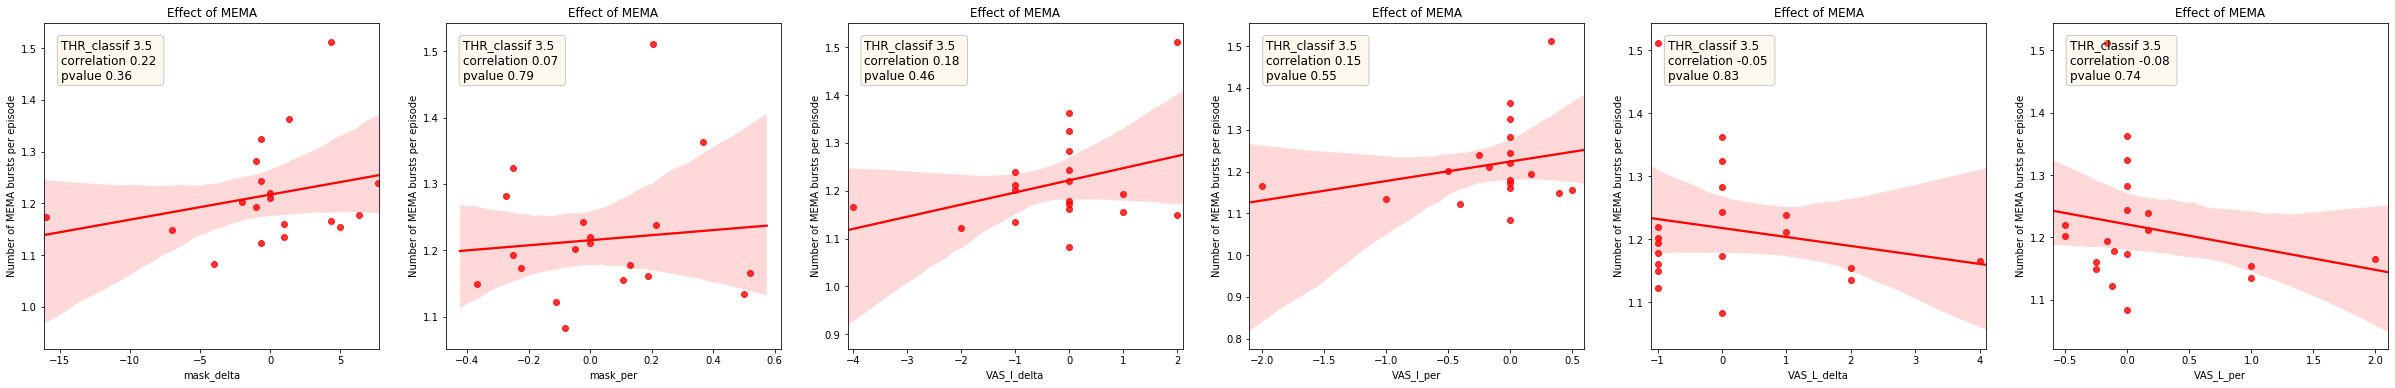

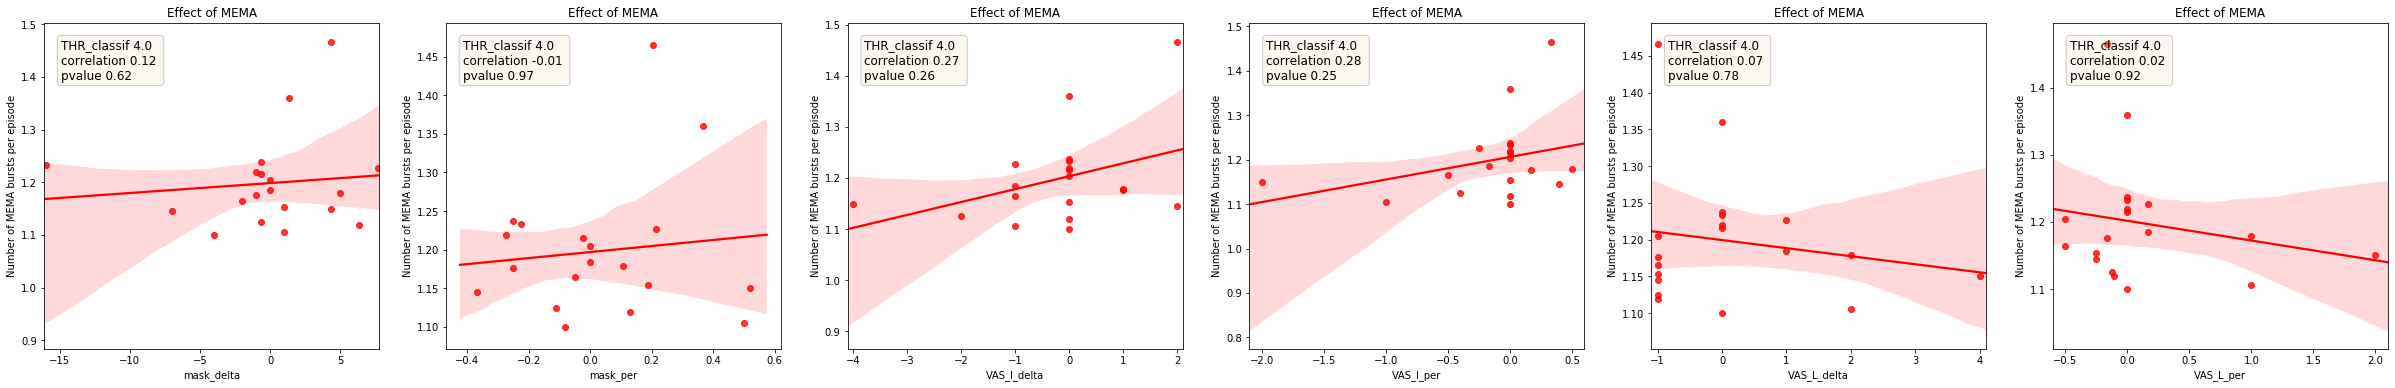

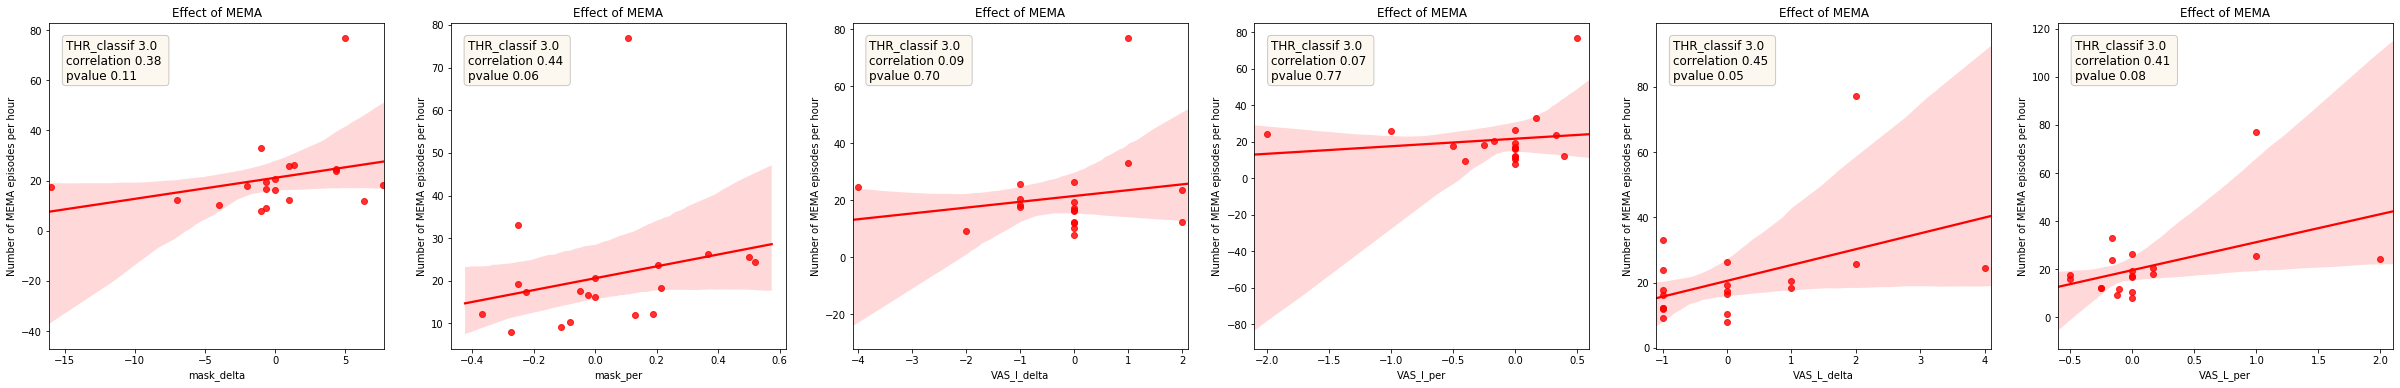

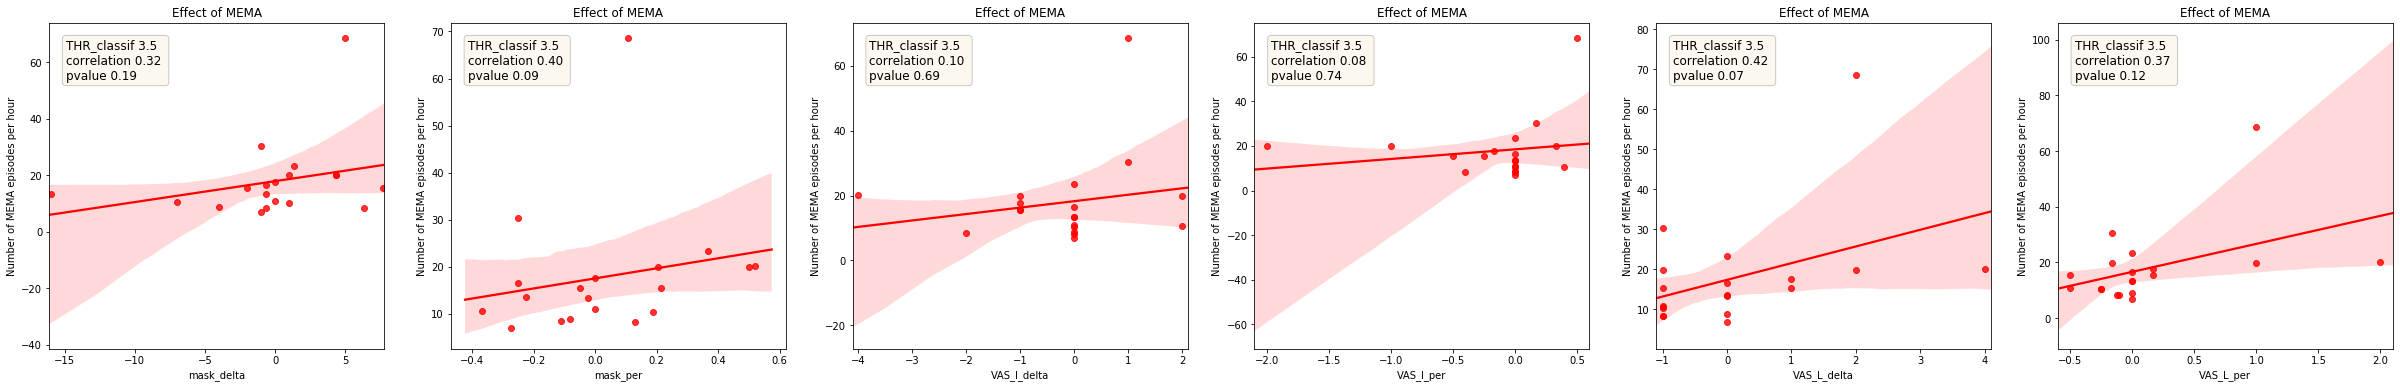

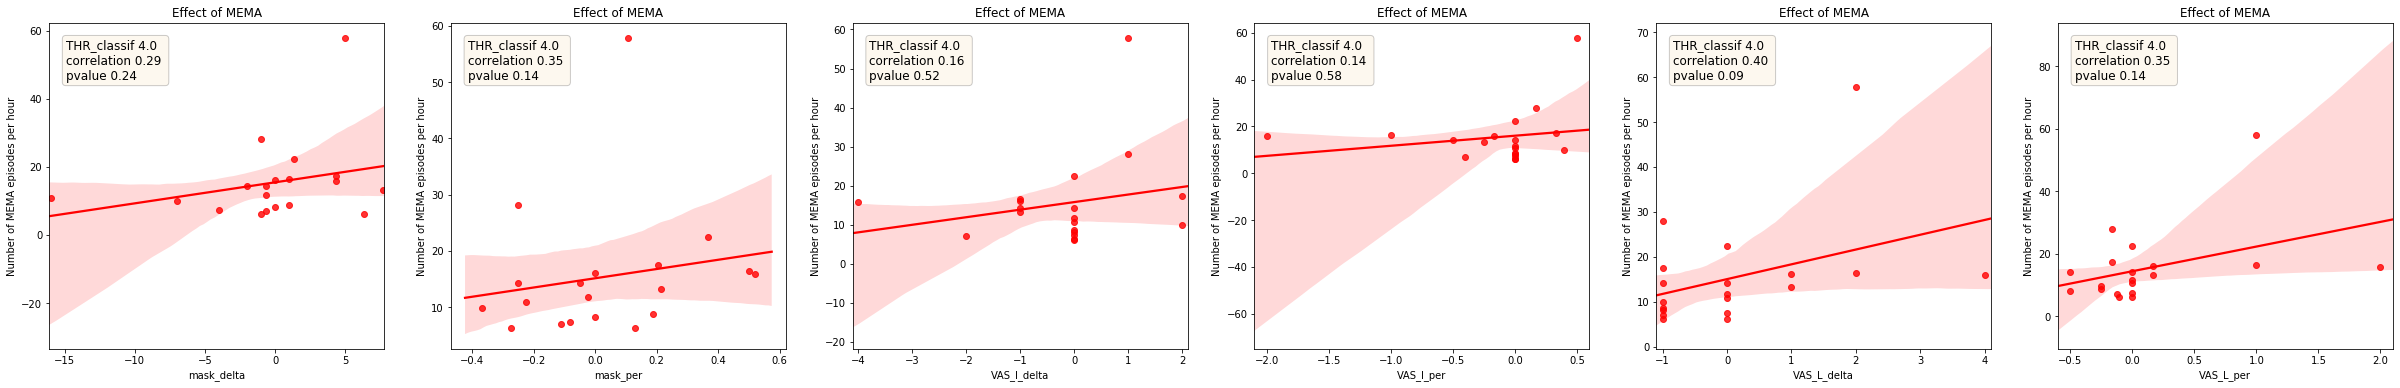

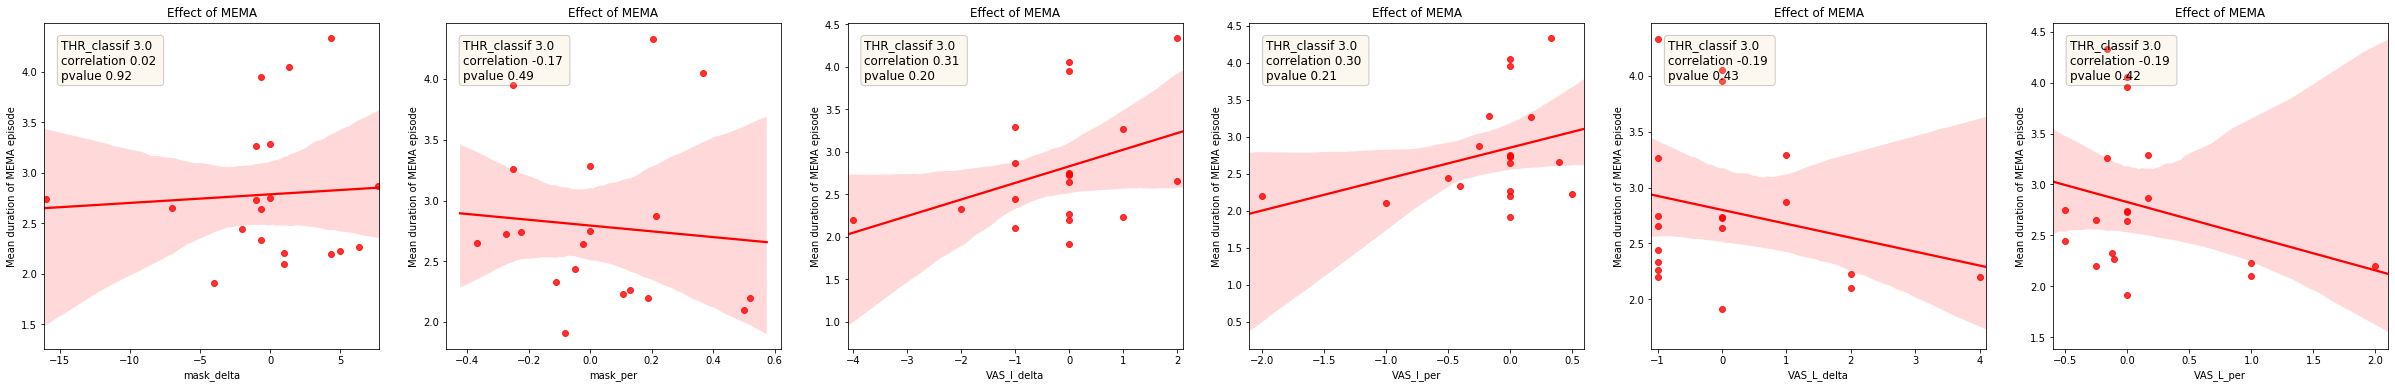

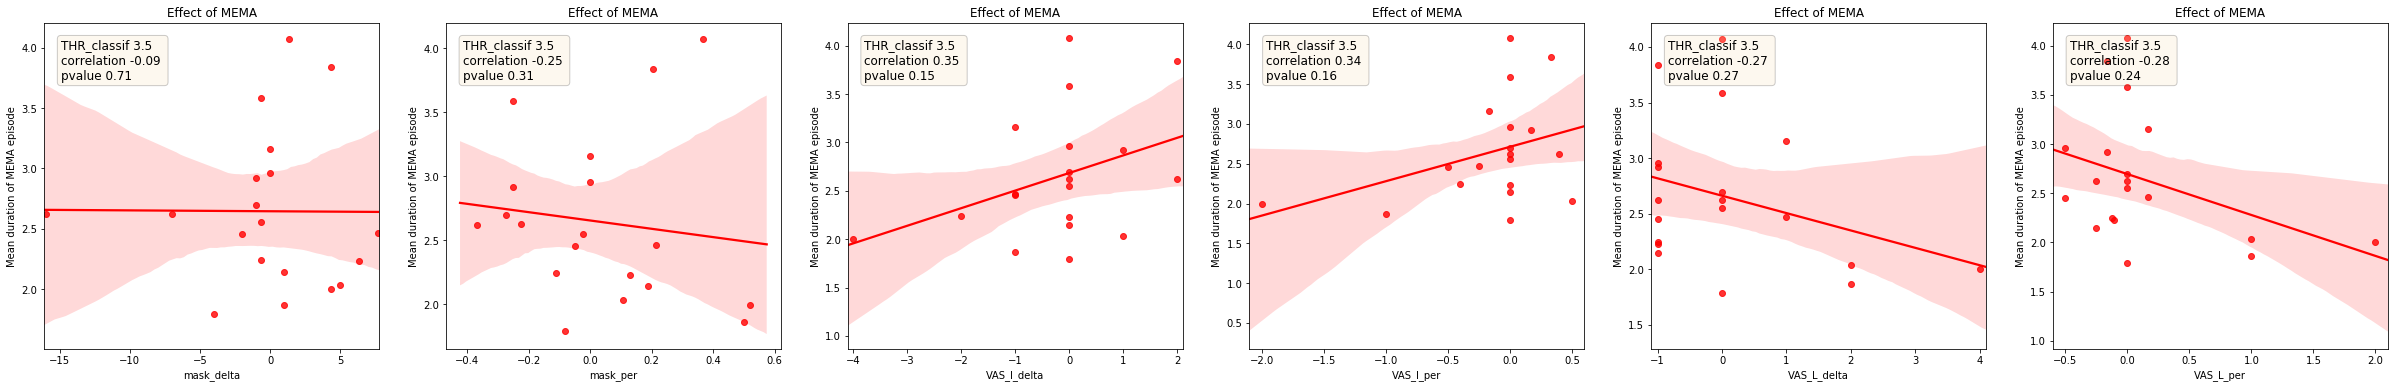

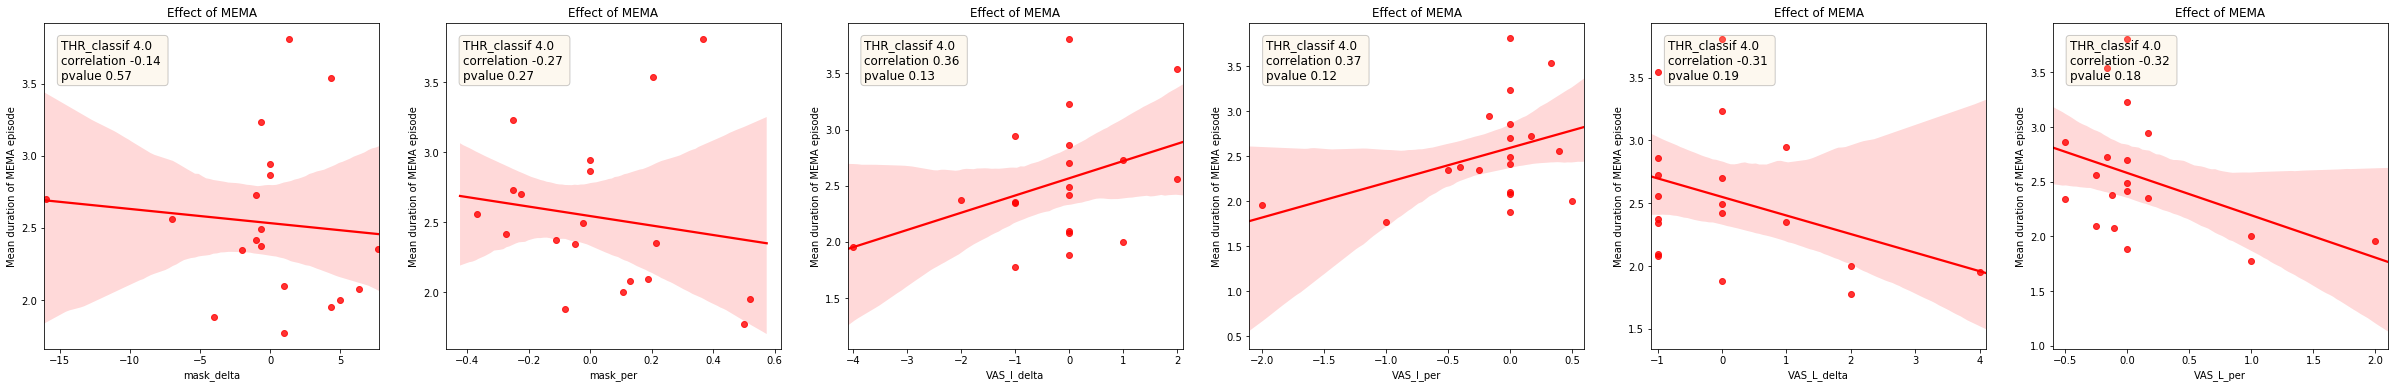

In [21]:
meta_results = pd.DataFrame()
import seaborn as sns
from tinnsleep.visualization import regression_report_with_plot
plt.close("all")

data = reports.query("category != 'control'")
meta_results = regression_report_with_plot(data, effect_variable, quantitative_variables, conditions='THR_classif', title="Effect of MEMA")

In [22]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,correlation,pvalue
0,mask_delta,Clean MEMA duration,3.0,0.470746,0.041930
0,mask_delta,Clean MEMA duration,3.5,0.470746,0.041930
0,mask_delta,Clean MEMA duration,4.0,0.470746,0.041930
0,mask_per,Number of MEMA bursts per hour,3.0,0.461809,0.046538
0,mask_delta,Number of MEMA bursts per episode,3.0,0.467226,0.043701


In [6]:
print(results["1AC26_cohort2.edf_right"]["reports"][0]['Total number of MEMA burst'])
print(results["1AC26_cohort2.edf_right"]["reports"][0]['Total number of MEMA episodes'])
print(len(results["1AC26_cohort2.edf_right"]["reports"][0]["peaks"]))
print(results["1AC26_cohort2.edf_right"]["reports"][0]["peaks"])

253
158
552
[3494, [(array([ 22,  39,  56,  77,  93, 109, 124, 149, 170, 185, 201, 226, 240],
      dtype=int64), {}), (array([1.78247230e-03, 1.42944003e-06, 1.26822417e-02, 2.90475847e-03,
       4.14433654e-02, 7.64500116e-04, 3.74461684e-03, 1.10803005e-02,
       3.52175564e-03, 2.60138248e-04, 8.76786228e-03, 4.94475521e-03,
       2.42802685e-03]), array([  0,  37,   0,  68,   0, 105, 118, 135, 164, 181, 189, 217, 234],
      dtype=int64), array([ 43,  43,  68,  83, 247, 247, 247, 247, 247, 189, 247, 247, 247],
      dtype=int64))], [(array([ 80, 108, 124, 137, 151, 192, 215], dtype=int64), {}), (array([2.41521249e-02, 1.05526334e-02, 6.86465591e-03, 2.73329943e-01,
       6.26057681e-05, 6.40437233e-05, 1.78937413e-02]), array([ 36,  36,  36,  36, 150, 191, 207], dtype=int64), array([ 88, 113, 130, 239, 239, 239, 239], dtype=int64))], [(array([ 37,  53,  66,  88,  98, 113, 129], dtype=int64), {}), (array([0.00247934, 0.00242968, 0.0216625 , 0.00074534, 0.01030272,
       0.0005

In [7]:
print(results["1AC26_cohort2.edf_right"]["reports"][0]["peaks"])
print(results["1AC26_cohort2.edf_right"]["reports"][0]["peaks"][1])

[3494, [(array([ 22,  39,  56,  77,  93, 109, 124, 149, 170, 185, 201, 226, 240],
      dtype=int64), {}), (array([1.78247230e-03, 1.42944003e-06, 1.26822417e-02, 2.90475847e-03,
       4.14433654e-02, 7.64500116e-04, 3.74461684e-03, 1.10803005e-02,
       3.52175564e-03, 2.60138248e-04, 8.76786228e-03, 4.94475521e-03,
       2.42802685e-03]), array([  0,  37,   0,  68,   0, 105, 118, 135, 164, 181, 189, 217, 234],
      dtype=int64), array([ 43,  43,  68,  83, 247, 247, 247, 247, 247, 189, 247, 247, 247],
      dtype=int64))], [(array([ 80, 108, 124, 137, 151, 192, 215], dtype=int64), {}), (array([2.41521249e-02, 1.05526334e-02, 6.86465591e-03, 2.73329943e-01,
       6.26057681e-05, 6.40437233e-05, 1.78937413e-02]), array([ 36,  36,  36,  36, 150, 191, 207], dtype=int64), array([ 88, 113, 130, 239, 239, 239, 239], dtype=int64))], [(array([ 37,  53,  66,  88,  98, 113, 129], dtype=int64), {}), (array([0.00247934, 0.00242968, 0.0216625 , 0.00074534, 0.01030272,
       0.00055087, 0.0016